# Introduction
------------

## Extremely Brief Probabilistic Programming Background
Probabilistic programming languages like `Pyro`, `Turing.jl`, `Gen.jl`, `Stan`, etc. (partially) automate the difficult task of probabilistic modeling and inference.

TLDR: Bayes Theorem is very flexible and powerful, but hard to work with!

These technologies build on techniques in programming languages theory, Bayesian statistics, and probabilistic machine learning to provide efficient model-agnostic approximate solutions to hard probabilsitic inference problems.

## General ASKEM Goal 1: 
Represent continuous-time dynamical systems models with uncertainty as probabilistic programs in a probabilistic programming language.

## General ASKEM Goal 2:
Represent ASKEM questions in terms of primitive query operations that PPLs (partially) automate for any probabilistic program. 

In `Pyro` and `CausalPyro`, the probabilistic programming languages we're using and developing: this includes operations like `sample`, `condition`, `intervene`, etc.

## Ensemble Challenge Goal:
Demonstrate how probabilsitic programming lets us think about probabilsitic models the way we think about software.

First, we'll demonstrate how we can build probabilistic ensemble models compositionally from probabilsitic ODE models, with very few lines of code, and without losing any probabilsitic modeling functionality.

Second, we'll show how to use our ASKEM-specific abstractions for building ensemble models in a no-code workflow. Using these abstractions, we'll make example forecasts based on historical data.

-----------

# A Brief Tour of Ensemble Modeling in PyCIEMSS

```python

class DynamicalSystem(pyro.nn.module):
    
    ...

    def forward(self, *args, **kwargs) -> Solution:
        '''
        Joint distribution over model parameters, trajectories, and noisy observations.
        '''
        # Setup the anything the dynamical system needs before solving.
        self.setup_before_solve()

        # Sample parameters from the prior
        self.param_prior()

        # "Solve" the Dynamical System
        solution = self.get_solution(*args, **kwargs)        

        # Add the observation likelihoods for probabilistic inference (if applicable)
        self.add_observation_likelihoods(solution)

        return self.log_solution(solution) 
```

```python

class ODESystem(DynamicalSystem):
    
    ...

    def param_prior(self):
        # Sample all of the parameters from the prior and store them as attributes of the ODESystem.
        ...
    
    def get_solution(*args, **kwargs):
        # Run an off-the-shelf ODE solver, using the parameters generated from the call to self.param_prior()
        # Make sure to evaluate at all points the user wants logged, and at all observations.
        ...
        local_solution = torchdiffeq.odeint(self.deriv, initial_state, local_tspan)
        ...
    
```

```python
class EnsembleSystem(DynamicalSystem):

        def __init__(self, 
                     models: List[DynamicalSystem], 
                     dirichlet_alpha: torch.tensor,
                     solution_mappings: Callable) -> None:

        self.models = models
        self.dirichlet_alpha = dirichlet_alpha
        self.solution_mappings = solution_mappings

    ...

    def param_prior(self):
        # The prior distribution over parameters in an ensemble is just the prior distribution over each constituent model's parameters.
        for i, model in enumerate(self.models):
            with scope(prefix=f'model_{i}'):
                model.param_prior()
    
    def get_solution(self, *args, **kwargs):
        
        # Sample model weights from a Dirichlet distribution
        model_weights = pyro.sample('model_weights', pyro.distributions.Dirichlet(self.dirichlet_alpha))

        # Solve the Dynamical System for each model in self.models, mapping outputs to the shared state representation.
        solutions = [mapping(model.get_solution(*args, **kwargs)) for model, mapping in zip(self.models, self.solution_mappings)]

        # Combine the ensemble solutions, scaled by `model_weights`.
        solution = {k: sum([model_weights[i] * v[k] for i, v in enumerate(solutions)]) for k in solutions[0].keys()}

        return solution
```


---

### Limitations

1. Fixed parameters for all time
2. Fixed mixture weights for all time

### Possible Future Developments

1. Translate ODE models to SDE models with time-varying stochastic parameters. (Be careful for reasons Chris R mentioned)
2. Allows mixture to weights to smoothly vary (with uncertainty) over time. 
    - Hidden markov model with local transitions over mixture weights
    - Gaussian process prior over time-varying dirichlet weights

# A Brief Tour of ASKEM-specific interfaces

Here we show how PyCIEMSS can be used in a no-code (or low-code) modeling workflow

In [1]:
# First, let's load the dependencies and set up the notebook environment.
import os

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

from pyciemss.PetriNetODE.interfaces import load_petri_model
from pyciemss.PetriNetODE.interfaces import sample as sample_petri
from pyciemss.PetriNetODE.interfaces import setup_model as setup_model_petri
from pyciemss.PetriNetODE.interfaces import intervene as intervene_petri
from pyciemss.PetriNetODE.interfaces import calibrate as calibrate_petri


from pyciemss.Ensemble.interfaces import setup_model, reset_model, intervene, sample, calibrate, optimize

## Load Data

In [2]:
print(os.getcwd())
# Load the data as a torch tensor.
DATA_PATH = "covid_data/"
data_filename = "US_case_hospital_death.csv"
data_filename = os.path.join(DATA_PATH, data_filename)

data = pd.read_csv(data_filename)

# Clip off the first 2 months of data
data_total_population = 331893745
train_start_date = "2021-12-01"
test_start_date = "2022-03-01"
test_end_date = "2022-04-01"

# data

/Users/mahs128/Repos/pyciemss/notebook/april_ensemble


In [3]:
def get_train_test_data(data: pd.DataFrame, train_start_date: str, test_start_date: str, test_end_date: str) -> pd.DataFrame:
    train_df = data[(data['date'] >= train_start_date) & (data['date'] < test_start_date)]
    train_data = [0] * train_df.shape[0]
    start_time = train_df.index[0]

    train_cases = np.array(train_df["case_census"].astype("float")) / data_total_population
    train_timepoints = np.array(train_df.index.astype("float"))

    test_df = data[(data['date'] >= test_start_date) & (data['date'] < test_end_date)]
    test_cases = np.array(test_df["case_census"].astype("float")) / data_total_population
    test_timepoints = np.array(test_df.index.astype("float"))

    for time, row in train_df.iterrows():
        row_dict = {}
        row_dict["Cases"] = row["case_census"] / data_total_population
        row_dict["Dead"] = row["cumulative_deaths"] / data_total_population
        if row["hospital_census"] > 0:
            row_dict["Hospitalizations"] = row["hospital_census"] / data_total_population

        index = time - start_time
        train_data[index] = (float(time), row_dict)
    
    all_timepoints = np.concatenate((train_timepoints, test_timepoints))

    return train_data, train_cases, train_timepoints, test_cases, test_timepoints, all_timepoints

In [4]:
# train_data, train_cases, train_timepoints, test_cases, test_timepoints, all_timepoints = get_train_test_data(data, train_start_date, test_start_date, test_end_date)

## Setup Models

### Model 1

In [143]:
MIRA_PATH = "../../test/models/april_ensemble_demo/"

filename1 = "BIOMD0000000955_template_model.json"
filename1 = os.path.join(MIRA_PATH, filename1)

model1 = load_petri_model(filename1, add_uncertainty=True)

# Load deterministic model by setting add_uncertainty=False 
# model1 = load_petri_model(filename1, add_uncertainty=False)

model1

ScaledBetaNoisePetriNetODESystem(
	beta = Uniform(low: 0.00989999994635582, high: 0.01209999993443489),
	gamma = Uniform(low: 0.41040000319480896, high: 0.5016000270843506),
	delta = Uniform(low: 0.00989999994635582, high: 0.01209999993443489),
	alpha = Uniform(low: 0.5130000114440918, high: 0.6269999742507935),
	epsilon = Uniform(low: 0.15389999747276306, high: 0.18809999525547028),
	zeta = Uniform(low: 0.11249999701976776, high: 0.13750000298023224),
	XXlambdaXX = Uniform(low: 0.03060000017285347, high: 0.03739999979734421),
	eta = Uniform(low: 0.11249999701976776, high: 0.13750000298023224),
	rho = Uniform(low: 0.03060000017285347, high: 0.03739999979734421),
	theta = Uniform(low: 0.33390000462532043, high: 0.4081000089645386),
	kappa = Uniform(low: 0.015300000086426735, high: 0.018699999898672104),
	mu = Uniform(low: 0.015300000086426735, high: 0.018699999898672104),
	nu = Uniform(low: 0.024299999698996544, high: 0.02969999983906746),
	xi = Uniform(low: 0.015300000086426735, high: 

In [6]:
def create_start_state1(data, start_date, total_pop):
    start_state = data.set_index('date').loc[start_date].to_dict()

    returned_state = {}
    returned_state["Extinct"] = start_state['cumulative_deaths']
    
    if np.isnan(start_state['hospital_census']):
        returned_state["Threatened"] = start_state['case_census'] / 100
    else:
        returned_state["Threatened"] = start_state['hospital_census']

    returned_state["Diagnosed"] = start_state['case_census'] / 2
    returned_state["Recognized"] = start_state['case_census'] / 2
    returned_state['Infected'] = start_state['case_census'] / 2 # * 10
    returned_state['Ailing'] = start_state['case_census'] / 2 # returned_state["Threatened"] * 100

    returned_state['Healed'] = start_state['cumulative_deaths'] * 10
    returned_state['Susceptible'] =  total_pop - sum(returned_state.values())
    #print(returned_state)
    assert(returned_state['Susceptible'] > 0)
    return {k:v/total_pop for k, v in returned_state.items()}

In [7]:
test_dates = pd.date_range(start=train_start_date, end=test_end_date, freq="1D")
test_dates = [date.strftime("%Y-%m-%d") for date in test_dates[1:-1]]

In [8]:
print("train_start_date", train_start_date)

# Check all dates to make sure no initial values are negative
[create_start_state1(data, date, data_total_population) for date in test_dates]

start_state1 = create_start_state1(data, train_start_date, data_total_population)
start_state1

train_start_date 2021-12-01


{'Extinct': 0.002354530664625813,
 'Threatened': 0.00012599815642804597,
 'Diagnosed': 0.0014301113146919957,
 'Recognized': 0.0014301113146919957,
 'Infected': 0.0014301113146919957,
 'Ailing': 0.0014301113146919957,
 'Healed': 0.023545306646258125,
 'Susceptible': 0.96825371927392}

In [9]:
{k: v*data_total_population for k, v in start_state1.items()}

{'Extinct': 781454.0,
 'Threatened': 41818.0,
 'Diagnosed': 474645.0,
 'Recognized': 474645.0,
 'Infected': 474645.0,
 'Ailing': 474645.0,
 'Healed': 7814539.999999999,
 'Susceptible': 321357353.0}

In [10]:
# Taken from "observables" in JSON file
def solution_mapping1(model1_solution: dict) -> dict:
    mapped_dict = {}
    mapped_dict["Cases"] = model1_solution["Diagnosed"] + model1_solution["Recognized"]
    mapped_dict["Hospitalizations"] = model1_solution["Threatened"]
    mapped_dict["Dead"] = model1_solution["Extinct"]
    return mapped_dict

## NOTE - This mapping from MIRA uses the same state variables multiple times. This violates the implicit mass balance assumption of this ensemble.

We changed the above mapping to ensure that each state variable was used only once.

### Model 2

In [11]:
filename2 = "BIOMD0000000960_template_model.json"
filename2 = os.path.join(MIRA_PATH, filename2)


# Load deterministic model by setting add_uncertainty=False 
model2 = load_petri_model(filename2, add_uncertainty=True)
# model2 = load_petri_model(filename2, add_uncertainty=False)

# TODO: put this into the interfaces
mira_start_state2 = {k[0]: v.data['initial_value'] for k, v in model2.G.variables.items()}

model2

/Users/mahs128/Repos/pyciemss/src/pyciemss/PetriNetODE/base.py:415: UserWarning: Parameter delta_A has value 0.0 <= 0.0 and will be set to Uniform(0, 0.1)
  warnings.warn(warnings_string)
/Users/mahs128/Repos/pyciemss/src/pyciemss/PetriNetODE/base.py:415: UserWarning: Parameter mira_param_9 has value 0.0 <= 0.0 and will be set to Uniform(0, 0.1)
  warnings.warn(warnings_string)


ScaledBetaNoisePetriNetODESystem(
	mira_param_0 = Uniform(low: 8.308957966107755e-10, high: 1.015539319304537e-09),
	mira_param_1 = Uniform(low: 3.398363812578964e-09, high: 4.153555721586599e-09),
	mira_param_2 = Uniform(low: 7.070923291330189e-10, high: 8.642239701650567e-10),
	mira_param_3 = Uniform(low: 0.02098800055682659, high: 0.025652000680565834),
	mira_param_4 = Uniform(low: 0.37501201033592224, high: 0.45834800601005554),
	mira_param_5 = Uniform(low: 0.0494999997317791, high: 0.060499999672174454),
	mira_param_6 = Uniform(low: 0.266400009393692, high: 0.3255999982357025),
	mira_param_7 = Uniform(low: 0.02070000022649765, high: 0.025299999862909317),
	mira_param_8 = Uniform(low: 1.4759999513626099, high: 1.8040000200271606),
	mira_param_9 = Uniform(low: 0.0, high: 0.10000000149011612),
	mira_param_10 = Uniform(low: 0.0002610000083222985, high: 0.00031900001340545714),
	mira_param_11 = Uniform(low: 0.016200000420212746, high: 0.01979999989271164),
	pseudocount = 1.0
)

In [12]:
mira_start_state2

{'Susceptible': 9900000.0,
 'Exposed': 36600.0,
 'Infectious': 732.0,
 'Asymptomatic': 2196.0,
 'Hospitalized': 0.0,
 'Recovered': 0.0,
 'Deceased': 0.0}

In [13]:
# model2_total_population = sum(mira_start_state2.values()) # this value is off

# Use hard-coded Total USA population used in this model
model2_total_population = model2.G.template_model.parameters['Total_pop_USA'].value 

def solution_mapping2(model2_solution: dict) -> dict:
    mapped_dict = {}
    mapped_dict["Cases"] = model2_solution["Infectious"] / model2_total_population
    mapped_dict["Hospitalizations"] = model2_solution["Hospitalized"] / model2_total_population
    mapped_dict["Dead"] = model2_solution["Deceased"] / model2_total_population
    return mapped_dict

ScaledBetaNoisePetriNetODESystem(
	mira_param_0 = Uniform(low: 8.308957966107755e-10, high: 1.015539319304537e-09),
	mira_param_1 = Uniform(low: 3.398363812578964e-09, high: 4.153555721586599e-09),
	mira_param_2 = Uniform(low: 7.070923291330189e-10, high: 8.642239701650567e-10),
	mira_param_3 = Uniform(low: 0.02098800055682659, high: 0.025652000680565834),
	mira_param_4 = Uniform(low: 0.37501201033592224, high: 0.45834800601005554),
	mira_param_5 = Uniform(low: 0.0494999997317791, high: 0.060499999672174454),
	mira_param_6 = Uniform(low: 0.266400009393692, high: 0.3255999982357025),
	mira_param_7 = Uniform(low: 0.02070000022649765, high: 0.025299999862909317),
	mira_param_8 = Uniform(low: 1.4759999513626099, high: 1.8040000200271606),
	mira_param_9 = Uniform(low: 0.0, high: 0.10000000149011612),
	mira_param_10 = Uniform(low: 0.0002610000083222985, high: 0.00031900001340545714),
	mira_param_11 = Uniform(low: 0.016200000420212746, high: 0.01979999989271164),
	pseudocount = 1.0
)

In [14]:
# def create_start_state2(data, start_date, m2_total_pop, data_total_pop):
#     start_state = data.set_index('date').loc[start_date].to_dict()

#     returned_state = {}
#     returned_state["Deceased"] = start_state['cumulative_deaths']
    
#     if np.isnan(start_state['hospital_census']):
#         returned_state["Hospitalized"] = start_state['case_census'] / 100
#     else:
#         returned_state["Hospitalized"] = start_state['hospital_census']
    
#     returned_state["Infectious"] = start_state['case_census']

#     returned_state['Exposed'] = start_state['case_census'] * 2 # * 20
#     returned_state['Asymptomatic'] = start_state['case_census'] # * 10

#     returned_state['Recovered'] = start_state['cumulative_deaths'] * 10

#     returned_state['Susceptible'] =  data_total_pop - sum(returned_state.values())
#     assert(returned_state['Susceptible'] > 0)
#     return {k:v*(m2_total_pop/data_total_pop) for k, v in returned_state.items()}



def create_start_state2(data, start_date, m2_total_pop, data_total_pop):
    start_state = data.set_index('date').loc[start_date].to_dict()

    returned_state = {}
    returned_state["Deceased"] = start_state['cumulative_deaths']
    
    if np.isnan(start_state['hospital_census']):
        returned_state["Hospitalized"] = start_state['case_census'] / 100
    else:
        returned_state["Hospitalized"] = start_state['hospital_census']
    
    returned_state["Infectious"] = start_state['case_census']

    returned_state['Exposed'] = start_state['case_census'] * 2 # * 20
    returned_state['Asymptomatic'] = start_state['case_census'] # * 10

    returned_state['Recovered'] = start_state['cumulative_deaths'] * 10

    returned_state['Susceptible'] =  data_total_pop - sum(returned_state.values())
    assert(returned_state['Susceptible'] > 0)
    return {k:v*m2_total_pop/data_total_pop for k, v in returned_state.items()}

In [15]:
print("train_start_date", train_start_date)
[create_start_state2(data, date, model2_total_population, data_total_population) for date in test_dates]
start_state2 = create_start_state2(data, train_start_date, model2_total_population, data_total_population)
start_state2

train_start_date 2021-12-01


{'Deceased': 772756.9641301917,
 'Hospitalized': 41352.594939684685,
 'Infectious': 938725.0669638261,
 'Exposed': 1877450.1339276521,
 'Asymptomatic': 938725.0669638261,
 'Recovered': 7727569.641301917,
 'Susceptible': 315903420.5317729}

### Model 3

In [16]:
filename3 = "BIOMD0000000983_template_model.json"
filename3 = os.path.join(MIRA_PATH, filename3)

# Load deterministic model by setting add_uncertainty=False 
model3 = load_petri_model(filename3, add_uncertainty=True)
# model3 = load_petri_model(filename3, add_uncertainty=False)

# TODO: put this into the interfaces
mira_start_state3 = {k[0]: v.data['initial_value'] for k, v in model3.G.variables.items()}
mira_start_state3['Deceased'] = 0.0

model3

ScaledBetaNoisePetriNetODESystem(
	mira_param_0 = Uniform(low: 7.614000097078133e-09, high: 9.306000414710525e-09),
	mira_param_1 = Uniform(low: 1.5228000194156266e-08, high: 1.861200082942105e-08),
	mira_param_2 = Uniform(low: 1.9035000242695332e-09, high: 2.326500103677631e-09),
	mira_param_3 = Uniform(low: 3.8070000485390665e-09, high: 4.653000207355262e-09),
	mira_param_4 = Uniform(low: 0.019285714253783226, high: 0.023571427911520004),
	mira_param_5 = Uniform(low: 0.035999998450279236, high: 0.04399999976158142),
	mira_param_6 = Uniform(low: 0.14399999380111694, high: 0.17599999904632568),
	mira_param_7 = Uniform(low: 0.09000000357627869, high: 0.10999999940395355),
	mira_param_8 = Uniform(low: 0.22499999403953552, high: 0.2750000059604645),
	mira_param_9 = Uniform(low: 0.044999998062849045, high: 0.054999999701976776),
	mira_param_10 = Uniform(low: 0.015300000086426735, high: 0.018699999898672104),
	pseudocount = 1.0
)

In [17]:
model3_total_population = sum(mira_start_state3.values())

# Get hospitalization rate from the model
hosp_ratio = model3.G.template_model.parameters['h'].value 

def solution_mapping3(model3_solution: dict) -> dict:
    mapped_dict = {}
    # Ideally we would make better use of this distinction between "reported" and "unreported".
    # However, as other models don't include this distinction, we must instead sum them together to make solution outputs comparable.
    mapped_dict["Cases"] = model3_solution["Infected_reported"] / model3_total_population
    mapped_dict["Hospitalizations"] = (model3_solution["Infected_reported"] * hosp_ratio) / model3_total_population # (model3_solution["Infected_unreported"] * hosp_ratio) / model3_total_population
    mapped_dict["Dead"] = (model3_solution["Deceased"]) / model3_total_population
    return mapped_dict


In [18]:
mira_start_state3

{'Susceptible_unconfined': 66990000.0,
 'Exposed': 112.0,
 'Infected_reported': 12.0,
 'Infected_unreported': 50.0,
 'Quarantined': 36.0,
 'Recovered': 0.0,
 'Deceased': 0.0}

In [19]:
def create_start_state3(data, start_date, m3_total_pop, data_total_pop):
    start_state = data.set_index('date').loc[start_date].to_dict()

    returned_state = {}
    returned_state["Deceased"] = start_state['cumulative_deaths']
    
    # Hospitalization rates in model3 are just a scalar multiple of case_census. 
    # Initializing here may lead to contradiction for the Infected_reported variable
    # Instead assume initial quarantined individuals are equal to those hospitalized in data
    if np.isnan(start_state['hospital_census']):
        returned_state["Quarantined"] = start_state['case_census'] * 0.01
    else:
        returned_state["Quarantined"] = start_state['hospital_census']
    
    returned_state["Infected_reported"] = start_state['case_census']
    
    returned_state["Infected_unreported"] = start_state['case_census'] # Equivalent to asymptomatic, initially
        
    returned_state['Exposed'] = start_state['case_census'] * 2
    
    returned_state['Recovered'] = start_state['cumulative_deaths'] * 10
    
    returned_state['Susceptible_confined'] = 0
    returned_state['Susceptible_unconfined'] =  data_total_pop - sum(returned_state.values())
    assert(returned_state['Susceptible_unconfined'] > 0)
    return {k:v*m3_total_pop/data_total_pop for k, v in returned_state.items()}

In [20]:
[create_start_state3(data, date, model3_total_population, data_total_population) for date in test_dates]
start_state3 = create_start_state3(data, train_start_date, model3_total_population, data_total_population)
start_state3

{'Deceased': 157730.50367472277,
 'Quarantined': 8440.642958727649,
 'Infected_reported': 191606.91458918576,
 'Infected_unreported': 191606.91458918576,
 'Exposed': 383213.8291783715,
 'Recovered': 1577305.0367472277,
 'Susceptible_confined': 0.0,
 'Susceptible_unconfined': 64480306.15826257}

In [21]:
print("start_state1-Scaled")
display({k: v*data_total_population for k, v in start_state1.items()})

print(" ")

print("start_state2-Scaled")
display({k: v*data_total_population/model2_total_population for k, v in start_state2.items()})

print(" ")

print("start_state3-Scaled")
display({k: v*data_total_population/model3_total_population for k, v in start_state3.items()})


start_state1-Scaled


{'Extinct': 781454.0,
 'Threatened': 41818.0,
 'Diagnosed': 474645.0,
 'Recognized': 474645.0,
 'Infected': 474645.0,
 'Ailing': 474645.0,
 'Healed': 7814539.999999999,
 'Susceptible': 321357353.0}

 
start_state2-Scaled


{'Deceased': 781454.0,
 'Hospitalized': 41818.0,
 'Infectious': 949290.0,
 'Exposed': 1898580.0,
 'Asymptomatic': 949290.0,
 'Recovered': 7814540.0,
 'Susceptible': 319458773.0}

 
start_state3-Scaled


{'Deceased': 781454.0,
 'Quarantined': 41818.0,
 'Infected_reported': 949290.0,
 'Infected_unreported': 949290.0,
 'Exposed': 1898580.0,
 'Recovered': 7814540.0,
 'Susceptible_confined': 0.0,
 'Susceptible_unconfined': 319458772.99999994}

In [22]:
print(f"Model 1 mapped start state is {solution_mapping1(start_state1)}")
print(f"Model 2 mapped start state is {solution_mapping2(start_state2)}")
print(f"Model 3 mapped start state is {solution_mapping3(start_state3)}")

Model 1 mapped start state is {'Cases': 0.0028602226293839915, 'Hospitalizations': 0.00012599815642804597, 'Dead': 0.002354530664625813}
Model 2 mapped start state is {'Cases': 0.0028602226293839915, 'Hospitalizations': 0.00012599815642804597, 'Dead': 0.002354530664625813}
Model 3 mapped start state is {'Cases': 0.0028602226293839915, 'Hospitalizations': 0.00014301113146919958, 'Dead': 0.002354530664625813}


In [23]:
print(f"Model 2 total population is {model2_total_population}")
print(f"Model 3 total population is {model3_total_population}")
print("These values are not equal, initiate reachback to TA1 and TA2!")

Model 2 total population is 328200000.0
Model 3 total population is 66990210.0
These values are not equal, initiate reachback to TA1 and TA2!


In [24]:
# Assert that all of the variables in the solution mappings are the same.
assert(set(solution_mapping1(start_state1).keys()) 
       == set(solution_mapping2(start_state2).keys())
       == set(solution_mapping3(start_state3).keys()))

## Setup some plotting utilities

In [91]:
def setup_ax(ax=None):

    if not ax:
        fig = plt.figure(facecolor='w', figsize=(9, 9))
        ax = fig.add_subplot(111, axisbelow=True)

    ax.set_xlabel('Time since start of pandemic (days)')
    ax.set_ylabel('Cases (Prop. of Population)')
    ax.set_yscale('log')
    return ax

def plot_trajectory(prediction, tspan, ax=None, alpha=0.2, color="black", **kwargs):
    tspan = torch.as_tensor(tspan)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    I = prediction["Cases_sol"].detach().numpy().squeeze()
    ax.plot(tspan, I, alpha=0.5, lw=2, color=color, **kwargs)
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)

    return ax

def plot_predictive(prediction, tspan, var_name="Cases_sol", ax=None, title=None, alpha=0.2, color="black", **kwargs):
    tspan = torch.as_tensor(tspan)
    indeces = torch.ones_like(tspan).bool()
    
    I_low = torch.quantile(prediction[var_name], 0.05, dim=0).detach().numpy()
    I_up = torch.quantile(prediction[var_name], 0.95, dim=0).detach().numpy()

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    if title:
        ax.set_title(title)

    ax.fill_between(tspan[indeces], I_low[indeces], I_up[indeces], alpha=alpha, color=color, **kwargs)

    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)

    return ax

def plot_observations(data, tspan,  ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None, ):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ax.plot(tspan, data, color, alpha=alpha, lw=lw, marker=marker, label=label)
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    
    return ax

from pyro.distributions import Dirichlet
import matplotlib.tri as tri

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)

# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)

# Adapted from https://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/
def plot_weights(samples, ax=None, title=None, concentration=20, nlevels=200, subdiv=7, **kwargs):
    import math
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)

    points = torch.tensor(np.array([(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]))
    points /= torch.sum(points, dim=1, keepdim=True)

    alpha = samples * concentration
    vals = torch.stack([torch.exp(Dirichlet(alpha).log_prob(points[i,:])) for i in range(points.shape[0])])
    vals /= torch.max(vals, dim=0, keepdim=True)[0]
    vals = torch.sum(vals, dim=1)
    vals /= torch.sum(vals)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    if title:
        ax.set_title(title)

    mappable = ax.tricontourf(trimesh, vals, nlevels, cmap='jet', **kwargs)
    ax.axis('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 0.75**0.5)
    ax.axis('off')

    # label vertices "Model 1", "Model 2", and "Model 3"
    ax.text(-0.05, -0.08, 'Model 1', fontsize=14, ha='left')
    ax.text(1.05, -0.08, 'Model 2', fontsize=14, ha='right')
    ax.text(0.5,  0.75**0.5+0.03, 'Model 3', fontsize=14, ha='center')
    # add a colorbar with no numbers
    plt.colorbar(mappable, ticks=[], pad=0.1, ax=ax)
    return ax

# Begin data synthesis

In [26]:
# Create dictionary to organize solutions from each model
synth_data_dict = {}

## Define time values for synthetic data

In [140]:

# Setup timepoints
from pyciemss.utils import get_tspan

N_t = 100
t_points = get_tspan(1, N_t, 10*(N_t - 1) + 1) #get_tspan(1, all_timepoints[-1], len(all_timepoints)) # all_timepoints
# number of terms = 1 + (end - start)/step_size

start_t = 0

# note that we cannot intervene at a previously existing timepoint, or odeint will complain.
Num_param = 16
intervene_t = get_tspan(0.1, 0.9, Num_param)
print("t_points", t_points)
print("intervene_t", intervene_t)

t_points tensor([  1.0000,   1.1000,   1.2000,   1.3000,   1.4000,   1.5000,   1.6000,
          1.7000,   1.8000,   1.9000,   2.0000,   2.1000,   2.2000,   2.3000,
          2.4000,   2.5000,   2.6000,   2.7000,   2.8000,   2.9000,   3.0000,
          3.1000,   3.2000,   3.3000,   3.4000,   3.5000,   3.6000,   3.7000,
          3.8000,   3.9000,   4.0000,   4.1000,   4.2000,   4.3000,   4.4000,
          4.5000,   4.6000,   4.7000,   4.8000,   4.9000,   5.0000,   5.1000,
          5.2000,   5.3000,   5.4000,   5.5000,   5.6000,   5.7000,   5.8000,
          5.9000,   6.0000,   6.1000,   6.2000,   6.3000,   6.4000,   6.5000,
          6.6000,   6.7000,   6.8000,   6.9000,   7.0000,   7.1000,   7.2000,
          7.3000,   7.4000,   7.5000,   7.6000,   7.7000,   7.8000,   7.9000,
          8.0000,   8.1000,   8.2000,   8.3000,   8.4000,   8.5000,   8.6000,
          8.7000,   8.8000,   8.9000,   9.0000,   9.1000,   9.2000,   9.3000,
          9.4000,   9.5000,   9.6000,   9.7000,   9.800

### Setup Model 1 with intervention with fixed parameters (NEEDS CORRECTION)

In [28]:
# Choose model parameter distributions to intervene on selected specific values

# note that we cannot intervene at a previously existing timepoint, or odeint will complain.
# Intervention format: (time, parameter, value)

model1_rate_parameter_intervention = [
    (intervene_t[0], "beta", 0.01),
    (intervene_t[1], "gamma", 0.49),
    (intervene_t[2], "delta", 0.11),
    (intervene_t[3], "alpha", 0.61),
    (intervene_t[4], "epsilon", 0.17),
    (intervene_t[5], "zeta", 0.13),
    (intervene_t[6], "XXlambdaXX", 0.036),
    (intervene_t[7], "eta", 0.13),
    (intervene_t[8], "rho", 0.036),
    (intervene_t[9], "theta", 0.39),
    (intervene_t[10], "kappa", 0.017),
    (intervene_t[11], "mu", 0.017),
    (intervene_t[12], "nu", 0.028),
    (intervene_t[13], "xi", 0.017),
    (intervene_t[14], "tau", 0.009),
    (intervene_t[15], "sigma", 0.017)
]
print(model1_rate_parameter_intervention)


# Setup model with initial value
setup_model1 = setup_model_petri(model1, start_time=start_t, start_state=start_state1)#, solution_mappings=[solution_mapping1])

# Create intevened model
intervened_model1 = intervene_petri(setup_model1, model1_rate_parameter_intervention)
print(intervened_model1)

# # Simulate model predictions by sampling 1 prediction from the intervened model
N_samples = 1
model1_prediction = sample_petri(intervened_model1, timepoints=t_points, num_samples = N_samples)
model1_prediction


[(tensor(1.0000e-05), 'beta', 0.01), (tensor(2.0000e-05), 'gamma', 0.49), (tensor(3.0000e-05), 'delta', 0.11), (tensor(4.0000e-05), 'alpha', 0.61), (tensor(5.0000e-05), 'epsilon', 0.17), (tensor(6.0000e-05), 'zeta', 0.13), (tensor(7.0000e-05), 'XXlambdaXX', 0.036), (tensor(8.0000e-05), 'eta', 0.13), (tensor(9.0000e-05), 'rho', 0.036), (tensor(1.0000e-04), 'theta', 0.39), (tensor(0.0001), 'kappa', 0.017), (tensor(0.0001), 'mu', 0.017), (tensor(0.0001), 'nu', 0.028), (tensor(0.0001), 'xi', 0.017), (tensor(0.0001), 'tau', 0.009), (tensor(0.0002), 'sigma', 0.017)]
ScaledBetaNoisePetriNetODESystem(
	beta = Uniform(low: 0.00989999994635582, high: 0.01209999993443489),
	gamma = Uniform(low: 0.41040000319480896, high: 0.5016000270843506),
	delta = Uniform(low: 0.00989999994635582, high: 0.01209999993443489),
	alpha = Uniform(low: 0.5130000114440918, high: 0.6269999742507935),
	epsilon = Uniform(low: 0.15389999747276306, high: 0.18809999525547028),
	zeta = Uniform(low: 0.11249999701976776, high

{'beta': tensor([0.0100]),
 'gamma': tensor([0.4183]),
 'delta': tensor([0.0108]),
 'alpha': tensor([0.5412]),
 'epsilon': tensor([0.1722]),
 'zeta': tensor([0.1159]),
 'XXlambdaXX': tensor([0.0340]),
 'eta': tensor([0.1234]),
 'rho': tensor([0.0359]),
 'theta': tensor([0.3995]),
 'kappa': tensor([0.0156]),
 'mu': tensor([0.0156]),
 'nu': tensor([0.0284]),
 'xi': tensor([0.0157]),
 'tau': tensor([0.0094]),
 'sigma': tensor([0.0168]),
 'Ailing_sol': tensor([[1.1604e-03, 1.1483e-03, 1.1386e-03, 1.1313e-03, 1.1264e-03, 1.1237e-03,
          1.1233e-03, 1.1252e-03, 1.1292e-03, 1.1355e-03, 1.1438e-03, 1.1543e-03,
          1.1670e-03, 1.1818e-03, 1.1986e-03, 1.2176e-03, 1.2387e-03, 1.2620e-03,
          1.2873e-03, 1.3148e-03, 1.3445e-03, 1.3763e-03, 1.4104e-03, 1.4466e-03,
          1.4851e-03, 1.5259e-03, 1.5690e-03, 1.6145e-03, 1.6623e-03, 1.7126e-03,
          1.7654e-03, 1.8208e-03, 1.8787e-03, 1.9392e-03, 2.0025e-03, 2.0685e-03,
          2.1374e-03, 2.2091e-03, 2.2839e-03, 2.3616e-03

### Generate solution from intervened Model 1

In [161]:
# print(model1_prediction.keys())
state_var_names = ['Ailing_sol', 'Diagnosed_sol', 'Extinct_sol', 'Healed_sol', 'Infected_sol', 'Recognized_sol', 'Susceptible_sol', 'Threatened_sol']
state_var_sol_dict = {}
for n in state_var_names:
    state_var_sol_dict[n[0:-4]] = model1_prediction[n]

synth_data_dict['model1'] = solution_mapping1(state_var_sol_dict)
print(synth_data_dict['model1'].keys())
print(synth_data_dict['model1'])

dict_keys(['Cases', 'Hospitalizations', 'Dead'])
{'Cases': tensor([[0.0036, 0.0037, 0.0037, 0.0038, 0.0039, 0.0040, 0.0041, 0.0042, 0.0043,
         0.0044, 0.0045, 0.0046, 0.0047, 0.0048, 0.0049, 0.0050, 0.0051, 0.0053,
         0.0054, 0.0055, 0.0057, 0.0058, 0.0060, 0.0061, 0.0063, 0.0065, 0.0066,
         0.0068, 0.0070, 0.0072, 0.0074, 0.0076, 0.0078, 0.0081, 0.0083, 0.0085,
         0.0088, 0.0091, 0.0093, 0.0096, 0.0099, 0.0102, 0.0105, 0.0109, 0.0112,
         0.0115, 0.0119, 0.0123, 0.0127, 0.0131, 0.0135, 0.0139, 0.0144, 0.0148,
         0.0153, 0.0158, 0.0163, 0.0169, 0.0174, 0.0180, 0.0186, 0.0192, 0.0198,
         0.0205, 0.0212, 0.0219, 0.0226, 0.0233, 0.0241, 0.0249, 0.0257, 0.0266,
         0.0275, 0.0284, 0.0293, 0.0303, 0.0313, 0.0323, 0.0334, 0.0345, 0.0356,
         0.0367, 0.0379, 0.0392, 0.0404, 0.0418, 0.0431, 0.0445, 0.0459, 0.0474,
         0.0489, 0.0504, 0.0520, 0.0537, 0.0553, 0.0571, 0.0588, 0.0607, 0.0625,
         0.0644, 0.0664, 0.0684, 0.0705, 0.0726, 0

## Display prior forecasts for Model1 with intervened observation data

In [177]:
# DON'T RUN!!! num_samples set to 1000!!!!
# model1_prior_forecast = sample_petri(setup_model1, timepoints=t_points, num_samples = 1000)

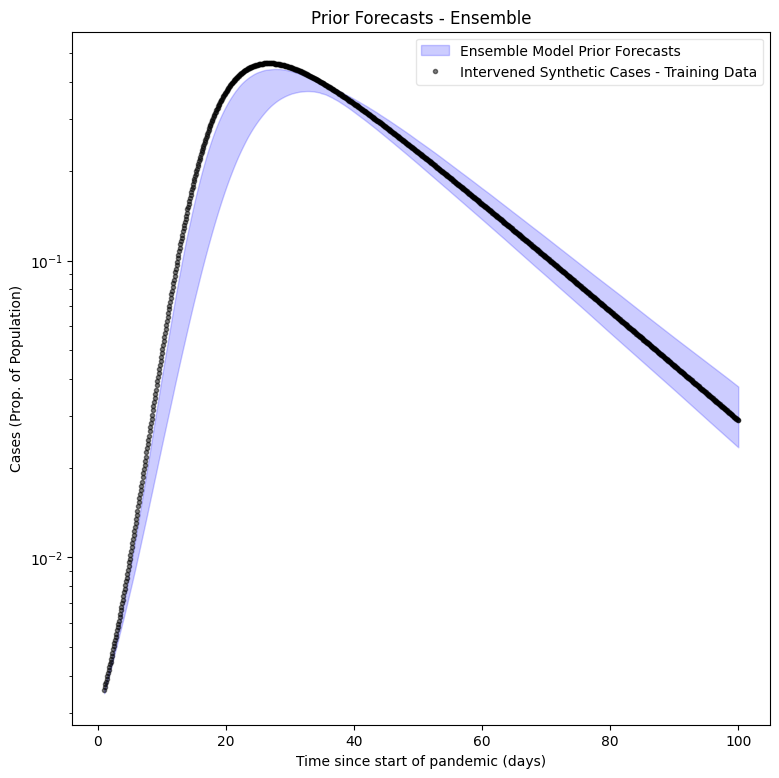

In [178]:
model1_prior_sol_dict = {}
for n in state_var_names:
    model1_prior_sol_dict[n[0:-4]] = model1_prior_forecast[n]

model1_solns = solution_mapping1(model1_prior_sol_dict)

# Fix solution names for plotting
new_model1_solns = {f"{k}_sol":v for k,v in model1_solns.items()}

ax = plot_predictive(new_model1_solns, t_points, ax=setup_ax(), title="Prior Forecasts - Ensemble (1000 Samples)", color="blue", label="Ensemble Model Prior Forecasts")
ax = plot_observations(synth_data_dict['model1']['Cases'][0], t_points, ax=ax, color="black", label="Intervened Synthetic Cases - Training Data")




### Setup Model 2 with intervention with fixed parameters (NEEDS CORRECTION)

In [30]:
model2

ScaledBetaNoisePetriNetODESystem(
	mira_param_0 = Uniform(low: 8.308957966107755e-10, high: 1.015539319304537e-09),
	mira_param_1 = Uniform(low: 3.398363812578964e-09, high: 4.153555721586599e-09),
	mira_param_2 = Uniform(low: 7.070923291330189e-10, high: 8.642239701650567e-10),
	mira_param_3 = Uniform(low: 0.02098800055682659, high: 0.025652000680565834),
	mira_param_4 = Uniform(low: 0.37501201033592224, high: 0.45834800601005554),
	mira_param_5 = Uniform(low: 0.0494999997317791, high: 0.060499999672174454),
	mira_param_6 = Uniform(low: 0.266400009393692, high: 0.3255999982357025),
	mira_param_7 = Uniform(low: 0.02070000022649765, high: 0.025299999862909317),
	mira_param_8 = Uniform(low: 1.4759999513626099, high: 1.8040000200271606),
	mira_param_9 = Uniform(low: 0.0, high: 0.10000000149011612),
	mira_param_10 = Uniform(low: 0.0002610000083222985, high: 0.00031900001340545714),
	mira_param_11 = Uniform(low: 0.016200000420212746, high: 0.01979999989271164),
	pseudocount = 1.0
)

In [131]:
# Choose model parameter distributions to intervene on selected specific values

# note that we cannot intervene at a previously existing timepoint, or odeint will complain.
# Intervention format: (time, parameter, value)

model2_rate_parameter_intervention = [
    (intervene_t[0], "mira_param_0", 1),#1e-9),
    (intervene_t[1], "mira_param_1", 4),#4e-9),
    (intervene_t[2], "mira_param_2", 0.85),#8.5e-10),
    (intervene_t[3], "mira_param_3", 0.024),
    (intervene_t[4], "mira_param_4", 0.44),
    (intervene_t[5], "mira_param_5", 0.059),
    (intervene_t[6], "mira_param_6", 0.31),
    (intervene_t[7], "mira_param_7", 0.024),
    (intervene_t[8], "mira_param_8", 1.7),
    (intervene_t[9], "mira_param_9", 0.09),
    (intervene_t[10], "mira_param_10", 0.0003),
    (intervene_t[11], "mira_param_11", 0.019)
]

# Setup model with initial value
setup_model2 = setup_model_petri(model2, start_time=start_t, start_state=start_state2)

# Create intevened model
intervened_model2 = intervene_petri(setup_model2, model2_rate_parameter_intervention)
print(intervened_model2)

# # Simulate model predictions by sampling 1 prediction from the intervened model
N_samples = 1
model2_prediction = sample_petri(intervened_model2, timepoints=t_points, num_samples = N_samples)
model2_prediction

ScaledBetaNoisePetriNetODESystem(
	mira_param_0 = Uniform(low: 8.308957966107755e-10, high: 1.015539319304537e-09),
	mira_param_1 = Uniform(low: 3.398363812578964e-09, high: 4.153555721586599e-09),
	mira_param_2 = Uniform(low: 7.070923291330189e-10, high: 8.642239701650567e-10),
	mira_param_3 = Uniform(low: 0.02098800055682659, high: 0.025652000680565834),
	mira_param_4 = Uniform(low: 0.37501201033592224, high: 0.45834800601005554),
	mira_param_5 = Uniform(low: 0.0494999997317791, high: 0.060499999672174454),
	mira_param_6 = Uniform(low: 0.266400009393692, high: 0.3255999982357025),
	mira_param_7 = Uniform(low: 0.02070000022649765, high: 0.025299999862909317),
	mira_param_8 = Uniform(low: 1.4759999513626099, high: 1.8040000200271606),
	mira_param_9 = Uniform(low: 0.0, high: 0.10000000149011612),
	mira_param_10 = Uniform(low: 0.0002610000083222985, high: 0.00031900001340545714),
	mira_param_11 = Uniform(low: 0.016200000420212746, high: 0.01979999989271164),
	pseudocount = 1.0
)


{'mira_param_0': tensor([8.5864e-10]),
 'mira_param_1': tensor([4.1115e-09]),
 'mira_param_2': tensor([7.9451e-10]),
 'mira_param_3': tensor([0.0232]),
 'mira_param_4': tensor([0.3814]),
 'mira_param_5': tensor([0.0500]),
 'mira_param_6': tensor([0.2860]),
 'mira_param_7': tensor([0.0214]),
 'mira_param_8': tensor([1.7265]),
 'mira_param_9': tensor([0.0516]),
 'mira_param_10': tensor([0.0003]),
 'mira_param_11': tensor([0.0169]),
 'Asymptomatic_sol': tensor([[  886912.7500,   921237.4375,   958413.1875,   998075.0000,
           1039954.1250,  1083850.7500,  1129622.6250,  1177172.2500,
           1226430.7500,  1277361.6250,  1329944.2500,  1384172.8750,
           1440056.6250,  1497611.2500,  1556860.0000,  1617833.1250,
           1680562.2500,  1745082.8750,  1811437.8750,  1879661.0000,
           1949797.2500,  2021884.8750,  2095966.5000,  2172086.2500,
           2250282.0000,  2330595.5000,  2413061.0000,  2497726.0000,
           2584615.5000,  2673773.7500,  2765229.7500,  

### Map solutions from intervened Model 2

In [132]:
print(model2_prediction.keys())

dict_keys(['mira_param_0', 'mira_param_1', 'mira_param_2', 'mira_param_3', 'mira_param_4', 'mira_param_5', 'mira_param_6', 'mira_param_7', 'mira_param_8', 'mira_param_9', 'mira_param_10', 'mira_param_11', 'Asymptomatic_sol', 'Deceased_sol', 'Exposed_sol', 'Hospitalized_sol', 'Infectious_sol', 'Recovered_sol', 'Susceptible_sol'])


In [133]:
# print(model1_prediction.keys())
state_var_names = ['Asymptomatic_sol', 'Deceased_sol', 'Exposed_sol', 'Hospitalized_sol', 'Infectious_sol', 'Recovered_sol', 'Susceptible_sol']
state_var_sol_dict = {}
for n in state_var_names:
    state_var_sol_dict[n[0:-4]] = model2_prediction[n]

synth_data_dict['model2'] = solution_mapping2(state_var_sol_dict)
print(synth_data_dict['model2'].keys())
print(synth_data_dict['model2'])

dict_keys(['Cases', 'Hospitalizations', 'Dead'])
{'Cases': tensor([[2.1308e-03, 2.0807e-03, 2.0340e-03, 1.9906e-03, 1.9504e-03, 1.9134e-03,
         1.8794e-03, 1.8484e-03, 1.8202e-03, 1.7949e-03, 1.7723e-03, 1.7525e-03,
         1.7352e-03, 1.7206e-03, 1.7085e-03, 1.6989e-03, 1.6918e-03, 1.6871e-03,
         1.6847e-03, 1.6848e-03, 1.6871e-03, 1.6918e-03, 1.6987e-03, 1.7079e-03,
         1.7194e-03, 1.7330e-03, 1.7489e-03, 1.7669e-03, 1.7871e-03, 1.8095e-03,
         1.8340e-03, 1.8606e-03, 1.8894e-03, 1.9203e-03, 1.9533e-03, 1.9884e-03,
         2.0256e-03, 2.0649e-03, 2.1063e-03, 2.1497e-03, 2.1953e-03, 2.2429e-03,
         2.2925e-03, 2.3442e-03, 2.3979e-03, 2.4536e-03, 2.5113e-03, 2.5711e-03,
         2.6328e-03, 2.6964e-03, 2.7620e-03, 2.8296e-03, 2.8990e-03, 2.9702e-03,
         3.0434e-03, 3.1183e-03, 3.1949e-03, 3.2734e-03, 3.3535e-03, 3.4352e-03,
         3.5185e-03, 3.6034e-03, 3.6898e-03, 3.7776e-03, 3.8668e-03, 3.9572e-03,
         4.0489e-03, 4.1418e-03, 4.2357e-03, 4.330

### Setup Model 3 with intervention with fixed parameters (NEEDS CORRECTION)

In [34]:
model3

ScaledBetaNoisePetriNetODESystem(
	mira_param_0 = Uniform(low: 7.614000097078133e-09, high: 9.306000414710525e-09),
	mira_param_1 = Uniform(low: 1.5228000194156266e-08, high: 1.861200082942105e-08),
	mira_param_2 = Uniform(low: 1.9035000242695332e-09, high: 2.326500103677631e-09),
	mira_param_3 = Uniform(low: 3.8070000485390665e-09, high: 4.653000207355262e-09),
	mira_param_4 = Uniform(low: 0.019285714253783226, high: 0.023571427911520004),
	mira_param_5 = Uniform(low: 0.035999998450279236, high: 0.04399999976158142),
	mira_param_6 = Uniform(low: 0.14399999380111694, high: 0.17599999904632568),
	mira_param_7 = Uniform(low: 0.09000000357627869, high: 0.10999999940395355),
	mira_param_8 = Uniform(low: 0.22499999403953552, high: 0.2750000059604645),
	mira_param_9 = Uniform(low: 0.044999998062849045, high: 0.054999999701976776),
	mira_param_10 = Uniform(low: 0.015300000086426735, high: 0.018699999898672104),
	pseudocount = 1.0
)

In [35]:
# Choose model parameter distributions to intervene on selected specific values

# note that we cannot intervene at a previously existing timepoint, or odeint will complain.
# Intervention format: (time, parameter, value)

model3_rate_parameter_intervention = [
    (intervene_t[0], "mira_param_0", 8e-9),
    (intervene_t[1], "mira_param_1", 1.7e-8),
    (intervene_t[2], "mira_param_2", 2.2e-9),
    (intervene_t[3], "mira_param_3", 4.5e-9),
    (intervene_t[4], "mira_param_4", 0.022),
    (intervene_t[5], "mira_param_5", 0.04),
    (intervene_t[6], "mira_param_6", .17),
    (intervene_t[7], "mira_param_7", .1),
    (intervene_t[8], "mira_param_8", .26),
    (intervene_t[9], "mira_param_9", .05),
    (intervene_t[10], "mira_param_10", .017)
]

# Setup model with initial value
setup_model3 = setup_model_petri(model3, start_time=start_t, start_state=start_state3)

# Create intevened model
intervened_model3 = intervene_petri(setup_model3, model3_rate_parameter_intervention)
print(intervened_model3)

# # Simulate model predictions by sampling 1 prediction from the intervened model
N_samples = 1
model3_prediction = sample_petri(intervened_model3, timepoints=t_points, num_samples = N_samples)
model3_prediction

ScaledBetaNoisePetriNetODESystem(
	mira_param_0 = Uniform(low: 7.614000097078133e-09, high: 9.306000414710525e-09),
	mira_param_1 = Uniform(low: 1.5228000194156266e-08, high: 1.861200082942105e-08),
	mira_param_2 = Uniform(low: 1.9035000242695332e-09, high: 2.326500103677631e-09),
	mira_param_3 = Uniform(low: 3.8070000485390665e-09, high: 4.653000207355262e-09),
	mira_param_4 = Uniform(low: 0.019285714253783226, high: 0.023571427911520004),
	mira_param_5 = Uniform(low: 0.035999998450279236, high: 0.04399999976158142),
	mira_param_6 = Uniform(low: 0.14399999380111694, high: 0.17599999904632568),
	mira_param_7 = Uniform(low: 0.09000000357627869, high: 0.10999999940395355),
	mira_param_8 = Uniform(low: 0.22499999403953552, high: 0.2750000059604645),
	mira_param_9 = Uniform(low: 0.044999998062849045, high: 0.054999999701976776),
	mira_param_10 = Uniform(low: 0.015300000086426735, high: 0.018699999898672104),
	pseudocount = 1.0
)


{'mira_param_0': tensor([8.6159e-09]),
 'mira_param_1': tensor([1.7197e-08]),
 'mira_param_2': tensor([1.9852e-09]),
 'mira_param_3': tensor([4.1179e-09]),
 'mira_param_4': tensor([0.0224]),
 'mira_param_5': tensor([0.0406]),
 'mira_param_6': tensor([0.1727]),
 'mira_param_7': tensor([0.1051]),
 'mira_param_8': tensor([0.2285]),
 'mira_param_9': tensor([0.0450]),
 'mira_param_10': tensor([0.0155]),
 'Deceased_sol': tensor([[160922.9375, 161234.4062, 161544.2344, 161852.6094, 162159.4219,
          162464.7188, 162768.4688, 163069.7969, 163369.9531, 163668.4531,
          163965.2031, 164260.1875, 164553.6562, 164845.2188, 165135.0469,
          165423.1094, 165709.4375, 165993.7344, 166276.3438, 166557.1250,
          166836.0625, 167113.1250, 167388.2656, 167661.9531, 167933.5156,
          168203.2344, 168471.1406, 168737.2500, 169001.0781, 169263.2500,
          169523.5469, 169781.9219, 170038.3750, 170292.8906, 170545.9375,
          170796.8125, 171045.7969, 171292.9062, 171538.1

### Generate solution from intervened Model 3

In [36]:
print(model3_prediction.keys())

dict_keys(['mira_param_0', 'mira_param_1', 'mira_param_2', 'mira_param_3', 'mira_param_4', 'mira_param_5', 'mira_param_6', 'mira_param_7', 'mira_param_8', 'mira_param_9', 'mira_param_10', 'Deceased_sol', 'Exposed_sol', 'Infected_reported_sol', 'Infected_unreported_sol', 'Quarantined_sol', 'Recovered_sol', 'Susceptible_unconfined_sol'])


In [37]:
# print(model1_prediction.keys())
state_var_names = ['Deceased_sol', 'Exposed_sol', 'Infected_reported_sol', 'Infected_unreported_sol', 'Quarantined_sol', 'Recovered_sol', 'Susceptible_unconfined_sol']
state_var_sol_dict = {}
for n in state_var_names:
    state_var_sol_dict[n[0:-4]] = model3_prediction[n]

synth_data_dict['model3'] = solution_mapping3(state_var_sol_dict)
print(synth_data_dict['model3'].keys())
print(synth_data_dict['model3'])

dict_keys(['Cases', 'Hospitalizations', 'Dead'])
{'Cases': tensor([[2.7413e-03, 2.7279e-03, 2.7143e-03, 2.7005e-03, 2.6865e-03, 2.6722e-03,
         2.6578e-03, 2.6432e-03, 2.6285e-03, 2.6136e-03, 2.5985e-03, 2.5833e-03,
         2.5680e-03, 2.5525e-03, 2.5370e-03, 2.5213e-03, 2.5055e-03, 2.4896e-03,
         2.4737e-03, 2.4576e-03, 2.4415e-03, 2.4253e-03, 2.4091e-03, 2.3928e-03,
         2.3764e-03, 2.3600e-03, 2.3436e-03, 2.3271e-03, 2.3106e-03, 2.2940e-03,
         2.2775e-03, 2.2609e-03, 2.2443e-03, 2.2278e-03, 2.2112e-03, 2.1946e-03,
         2.1780e-03, 2.1614e-03, 2.1449e-03, 2.1283e-03, 2.1118e-03, 2.0953e-03,
         2.0789e-03, 2.0624e-03, 2.0460e-03, 2.0296e-03, 2.0133e-03, 1.9970e-03,
         1.9808e-03, 1.9646e-03, 1.9484e-03, 1.9323e-03, 1.9163e-03, 1.9003e-03,
         1.8844e-03, 1.8685e-03, 1.8527e-03, 1.8369e-03, 1.8212e-03, 1.8056e-03,
         1.7901e-03, 1.7746e-03, 1.7592e-03, 1.7438e-03, 1.7286e-03, 1.7134e-03,
         1.6983e-03, 1.6832e-03, 1.6683e-03, 1.653

## Combine data from the Models 1, 2, & 3

In [114]:
# Assign weights for each model, and create a dictionary
weights = [0.5, 0.3, 0.2]
model_weights = dict(zip(synth_data_dict.keys(), weights))

# Create a df containing the weighted sum of the different model solutions for each variable
model_names = synth_data_dict.keys()
var_names = synth_data_dict['model1'].keys()
new_synth_data_dict = {}
for vn in var_names:
    this_var = 0*synth_data_dict['model1'][vn][0]
    for mn in synth_data_dict.keys():
        this_var = this_var + model_weights[mn]*synth_data_dict[mn][vn][0]
    this_var = this_var*data_total_population # convert from pop percentage to case census counts
    new_synth_data_dict[vn] = this_var.numpy()
synth_data_df = pd.DataFrame.from_dict(new_synth_data_dict)

# keep only integer time values so there's one data point per day
keep_idx = [i for i,t in enumerate(t_points) if int(t) == t] # np.arange(0, 10*N_t + 1, 10)
synth_data_df = synth_data_df.iloc[keep_idx]
print(synth_data_df)

# add date column
from datetime import date, timedelta, datetime

start_date = date(2021, 12, 1)
date_col = [start_date]*len(synth_data_df)
for i in range(len(synth_data_df)):
    date_col[i] = f"{start_date + timedelta(days = i)}"
    
date_col
synth_data_df["Date"] = date_col #pd.DataFrame(Date = date_col, synth_data_df)
synth_data_df = synth_data_df.iloc[:, [3, 0, 2, 1]]

# reset dataframe index
synth_data_df = synth_data_df.reset_index(drop = True)
synth_data_df

# change dataframe column names to match expected testing data format
synth_data_df = synth_data_df.rename(columns = {"Date": "date", 
                                                "Cases": "case_census", 
                                                "Dead": "cumulative_deaths", 
                                                "Hospitalizations": "hospital_census"})
print(synth_data_df["case_census"]/data_total_population)
synth_data_df

           Cases  Hospitalizations          Dead
0     976701.875      6.737465e+04  8.082549e+05
10   1054124.875      8.926270e+04  8.249192e+05
20   1202654.250      1.105631e+05  8.365941e+05
30   1449693.250      1.333419e+05  8.452939e+05
40   1832550.000      1.599852e+05  8.521268e+05
..           ...               ...           ...
950  5692710.000      2.058235e+07  1.903185e+07
960  5456459.500      2.020661e+07  1.921530e+07
970  5229951.500      1.983420e+07  1.939540e+07
980  5012782.000      1.946529e+07  1.957216e+07
990  4804578.500      1.910005e+07  1.974562e+07

[100 rows x 3 columns]
0     0.002943
1     0.003176
2     0.003624
3     0.004368
4     0.005521
        ...   
95    0.017152
96    0.016440
97    0.015758
98    0.015104
99    0.014476
Name: case_census, Length: 100, dtype: float64


,date,case_census,cumulative_deaths,hospital_census
0,2021-12-01,976701.875,8.082549e+05,6.737465e+04
1,2021-12-02,1054124.875,8.249192e+05,8.926270e+04
2,2021-12-03,1202654.250,8.365941e+05,1.105631e+05
3,2021-12-04,1449693.250,8.452939e+05,1.333419e+05
4,2021-12-05,1832550.000,8.521268e+05,1.599852e+05
...,...,...,...,...
95,2022-03-06,5692710.000,1.903185e+07,2.058235e+07
96,2022-03-07,5456459.500,1.921530e+07,2.020661e+07
97,2022-03-08,5229951.500,1.939540e+07,1.983420e+07
98,2022-03-09,5012782.000,1.957216e+07,1.946529e+07


==> **Now, synth_data_df holds synthetic data constructed by combining data from the three models separately.**

In [120]:
# Make dataframe of solutions from each model separately
model1_df = pd.DataFrame.from_dict({k: synth_data_dict['model1'][k][0] for k in synth_data_dict['model1']})
model2_df = pd.DataFrame.from_dict({k: synth_data_dict['model2'][k][0] for k in synth_data_dict['model2']})
model3_df = pd.DataFrame.from_dict({k: synth_data_dict['model3'][k][0] for k in synth_data_dict['model3']})

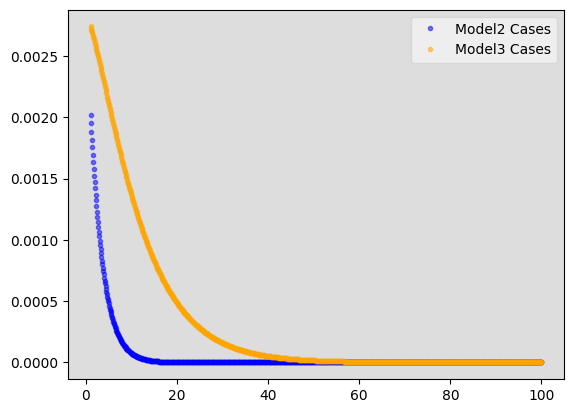

In [121]:
# Display synthetic data by plotting each model trajectory separately, along with the weighted sum data
# ax = plot_observations(model1_df['Cases'], t_points, color="red", label="Model1 Cases")
ax = plot_observations(model2_df['Cases'], t_points, color="blue", label="Model2 Cases")
ax = plot_observations(model3_df['Cases'], t_points, ax=ax, color="orange", label="Model3 Cases")
# ax = plot_observations(synth_data_df['case_census']/data_total_population, t_points[keep_idx], ax=ax, color="black", label="SynthData Cases")

# Calibrate Models using synthetic data

In [85]:
import pyro
autoguide = pyro.infer.autoguide.AutoDiagonalNormal

num_iterations = 150
num_samples = 100

In [ ]:
ensemble1 = setup_model([model1], weights=[1.0], start_time=start_t, start_states=[start_state1], solution_mappings=[solution_mapping1])
ensemble1_prior_forecasts = sample(ensemble1, t_points, num_samples)

In [148]:
train_data, train_cases, train_timepoints, test_cases, test_timepoints, all_timepoints = get_train_test_data(synth_data_model1, train_start_date, test_start_date, test_end_date)

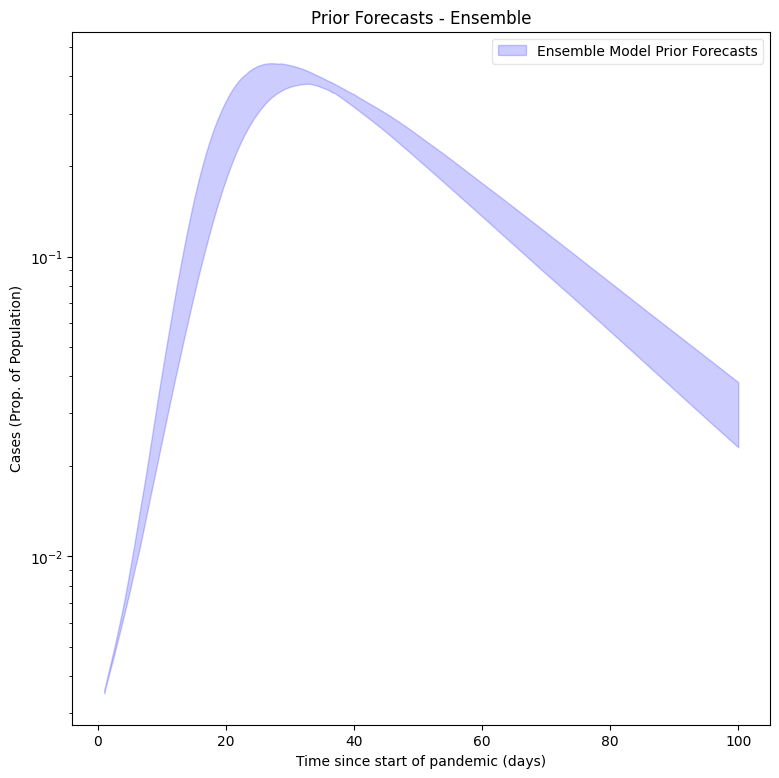

In [150]:
ax = plot_predictive(ensemble1_prior_forecasts, t_points, ax=setup_ax(), title="Prior Forecasts - Ensemble", color="blue", label="Ensemble Model Prior Forecasts")
# ax = plot_observations(train_cases, train_timepoints, ax=ax, color="black", label="Reported Cases - Training Data")
# ax = plot_observations(test_cases, test_timepoints, ax=ax, color="red", label="Reported Cases - Testing Data")
# # ax = plot_observations(plotting_cases, all_timepoints, ax=ax, color="black", label="Reported Cases"

## Test each model calibration separately using synthetic data generated by the corresponding models

### Calibrate Model 1 using Model 1 data

In [86]:
synth_data_model1 = pd.DataFrame.from_dict({
    'date': synth_data_df['date'],
    'case_census': synth_data_dict['model1']['Cases'][0][keep_idx]*data_total_population,
    'cumulative_deaths': synth_data_dict['model1']['Dead'][0][keep_idx]*data_total_population,
    'hospital_census': synth_data_dict['model1']['Hospitalizations'][0][keep_idx]*data_total_population,
})
synth_data_model1

,date,case_census,cumulative_deaths,hospital_census
0,2021-12-01,1.187180e+06,7.819268e+05,6.383251e+04
1,2021-12-02,1.480514e+06,7.826148e+05,8.975726e+04
2,2021-12-03,1.883264e+06,7.835578e+05,1.208741e+05
3,2021-12-04,2.459006e+06,7.848124e+05,1.594193e+05
4,2021-12-05,3.288783e+06,7.864582e+05,2.088072e+05
...,...,...,...,...
95,2022-03-06,1.138540e+07,3.708243e+07,4.114514e+07
96,2022-03-07,1.091290e+07,3.744933e+07,4.039403e+07
97,2022-03-08,1.045989e+07,3.780952e+07,3.964959e+07
98,2022-03-09,1.002555e+07,3.816303e+07,3.891212e+07


In [87]:
train_data, train_cases, train_timepoints, test_cases, test_timepoints, all_timepoints = get_train_test_data(synth_data_model1, train_start_date, test_start_date, test_end_date)

In [88]:
ensemble1on1 = setup_model([model1], weights=[1.0], start_time=start_t-1e-6, start_states=[start_state1], solution_mappings=[solution_mapping1])

inferred_parameters1on1 = calibrate(ensemble1on1, train_data, num_iterations=num_iterations, verbose=True, verbose_every=10, autoguide=autoguide)

ensemble_posterior_forecasts1on1 = sample(ensemble1on1, t_points, num_samples, inferred_parameters1on1)

iteration 0: loss = 138.27428793907166
iteration 10: loss = 122.54304933547974
iteration 20: loss = 120.23259973526001
iteration 30: loss = 112.11742734909058
iteration 40: loss = 102.81905150413513
iteration 50: loss = 98.54484272003174
iteration 60: loss = 92.7337498664856
iteration 70: loss = 88.7456636428833
iteration 80: loss = 80.27230715751648
iteration 90: loss = 88.5376410484314
iteration 100: loss = 79.26181507110596
iteration 110: loss = 80.43646335601807
iteration 120: loss = 82.15061140060425
iteration 130: loss = 79.1956148147583
iteration 140: loss = 79.56263494491577
iteration 150: loss = 80.94256258010864
iteration 160: loss = 80.37741947174072
iteration 170: loss = 79.98534893989563
iteration 180: loss = 79.85888266563416
iteration 190: loss = 80.50926399230957


In [93]:
train_cases

array([0.00357699, 0.00446081, 0.0056743 , 0.00740902, 0.00990914,
       0.01349568, 0.01858985, 0.02573116, 0.03557938, 0.04888415,
       0.06640206, 0.08874972, 0.11620676, 0.14852634, 0.18483676,
       0.22370461, 0.26335004, 0.30194326, 0.33786608, 0.36988826,
       0.39722388, 0.41950959, 0.43672449, 0.44910373, 0.45704656,
       0.46104409, 0.4616234 , 0.45930613, 0.45458452, 0.44790658,
       0.4396677 , 0.43021263, 0.41983379, 0.40877844, 0.3972507 ,
       0.38541926, 0.37342192, 0.36136915, 0.34934949, 0.33743452,
       0.32567936, 0.31412711, 0.30281048, 0.2917547 , 0.28097797,
       0.27049271, 0.26030738, 0.25042714, 0.240854  , 0.23158788,
       0.22262687, 0.21396715, 0.20560573, 0.19753612, 0.18975258,
       0.1822486 , 0.17501727, 0.1680517 , 0.1613442 , 0.15488745,
       0.14867408, 0.14269603, 0.13694642, 0.13141737, 0.12610197,
       0.12099251, 0.11608233, 0.11136422, 0.10683137, 0.10247721,
       0.0982954 , 0.09427914, 0.09042283, 0.08672033, 0.08316

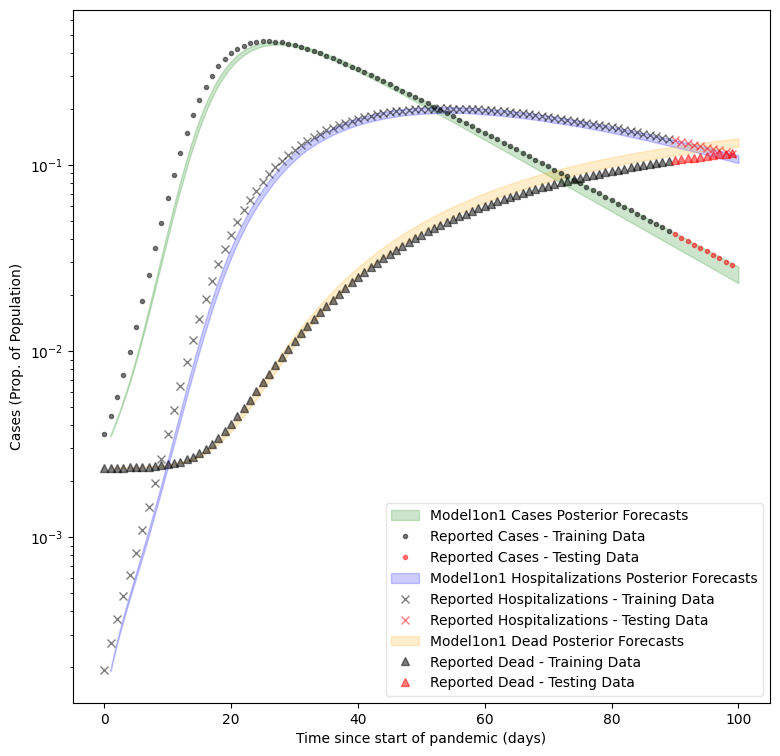

In [100]:
# Cases
ax = plot_predictive(ensemble_posterior_forecasts1on1, t_points, var_name="Cases_sol", ax=setup_ax(), color="green", label="Model1on1 Cases Posterior Forecasts")
ax = plot_observations(train_cases, train_timepoints, ax=ax, color="black", label="Reported Cases - Training Data")
ax = plot_observations(test_cases, test_timepoints, ax=ax, color="red", label="Reported Cases - Testing Data")

# Hospitalizations
train_df = synth_data_model1[(synth_data_model1['date'] >= train_start_date) & (synth_data_model1['date'] < test_start_date)]
test_df = synth_data_model1[(synth_data_model1['date'] >= test_start_date) & (synth_data_model1['date'] < test_end_date)]

train_hosps = np.array(train_df["hospital_census"].astype("float")) / data_total_population
test_hosps = np.array(test_df["hospital_census"].astype("float")) / data_total_population

train_dead = np.array(train_df["cumulative_deaths"].astype("float")) / data_total_population
test_dead = np.array(test_df["cumulative_deaths"].astype("float")) / data_total_population



ax = plot_predictive(ensemble_posterior_forecasts1on1, t_points, var_name="Hospitalizations_sol", ax=ax, color="blue", label="Model1on1 Hospitalizations Posterior Forecasts")
ax = plot_observations(train_hosps, train_timepoints, ax=ax, color="black", marker='x', label="Reported Hospitalizations - Training Data")
ax = plot_observations(test_hosps, test_timepoints, ax=ax, color="red", marker='x', label="Reported Hospitalizations - Testing Data")

ax = plot_predictive(ensemble_posterior_forecasts1on1, t_points, var_name="Dead_sol", ax=ax, color="orange", label="Model1on1 Dead Posterior Forecasts")
ax = plot_observations(train_dead, train_timepoints, ax=ax, color="black", marker='^', label="Reported Dead - Training Data")
ax = plot_observations(test_dead, test_timepoints, ax=ax, color="red", marker='^', label="Reported Dead - Testing Data")


In [90]:
param_median = {k[8:]: v[0].item() for k,v in inferred_parameters1on1.quantiles([0.50]).items()}
display(param_median)

param_actual = {b: c for (a,b,c) in model1_rate_parameter_intervention}
display(param_actual)

param_errs = {k:(v-param_median[k])/v for k,v in param_actual.items()}
display(param_errs)

{'beta': 0.011046187952160835,
 'gamma': 0.48922663927078247,
 'delta': 0.011205581948161125,
 'alpha': 0.6217612624168396,
 'epsilon': 0.15659654140472412,
 'zeta': 0.13013924658298492,
 'XXlambdaXX': 0.03153805807232857,
 'eta': 0.13174594938755035,
 'rho': 0.03202752023935318,
 'theta': 0.34924226999282837,
 'kappa': 0.016713302582502365,
 'mu': 0.017442386597394943,
 'nu': 0.02918539196252823,
 'xi': 0.015603776089847088,
 'tau': 0.010784883052110672,
 'sigma': 0.0157946590334177,
 'ights': 1.0}

{'beta': 0.01,
 'gamma': 0.49,
 'delta': 0.11,
 'alpha': 0.61,
 'epsilon': 0.17,
 'zeta': 0.13,
 'XXlambdaXX': 0.036,
 'eta': 0.13,
 'rho': 0.036,
 'theta': 0.39,
 'kappa': 0.017,
 'mu': 0.017,
 'nu': 0.028,
 'xi': 0.017,
 'tau': 0.009,
 'sigma': 0.017}

{'beta': -0.1046187952160835,
 'gamma': 0.0015782872024847356,
 'delta': 0.8981310731985352,
 'alpha': -0.019280758060392807,
 'epsilon': 0.07884387408985817,
 'zeta': -0.0010711275614224604,
 'XXlambdaXX': 0.12394283132420639,
 'eta': -0.013430379904233458,
 'rho': 0.11034666001796715,
 'theta': 0.10450700001838882,
 'kappa': 0.01686455397044918,
 'mu': -0.02602274102323188,
 'nu': -0.04233542723315101,
 'xi': 0.08213081824428901,
 'tau': -0.1983203391234081,
 'sigma': 0.07090240979895879}

### Calibrate Model 2 using Model 2 data

In [101]:
synth_data_model2 = pd.DataFrame.from_dict({
    'date': synth_data_df['date'],
    'case_census': synth_data_dict['model2']['Cases'][0][keep_idx]*data_total_population,
    'cumulative_deaths': synth_data_dict['model2']['Dead'][0][keep_idx]*data_total_population,
    'hospital_census': synth_data_dict['model2']['Hospitalizations'][0][keep_idx]*data_total_population,
})
synth_data_model2

,date,case_census,cumulative_deaths,hospital_census
0,2021-12-01,670490.562500,859459.6250,87867.351562
1,2021-12-02,471269.812500,903812.5000,119199.218750
2,2021-12-03,329859.343750,931675.5625,140076.562500
3,2021-12-04,230045.375000,949707.4375,153578.250000
4,2021-12-05,159927.828125,961485.6250,161908.843750
...,...,...,...,...
95,2022-03-06,0.000004,986258.3750,32593.519531
96,2022-03-07,0.000004,986266.5625,31970.482422
97,2022-03-08,0.000004,986277.6250,31359.380859
98,2022-03-09,0.000004,986286.8750,30759.949219


In [102]:
train_data, train_cases, train_timepoints, test_cases, test_timepoints, all_timepoints = get_train_test_data(synth_data_model2, train_start_date, test_start_date, test_end_date)

In [103]:
ensemble2on2 = setup_model([model2], weights=[1.0], start_time=start_t-1e-6, start_states=[start_state2], solution_mappings=[solution_mapping2])

inferred_parameters2on2 = calibrate(ensemble2on2, train_data, num_iterations=num_iterations, verbose=True, verbose_every=10, autoguide=autoguide)

ensemble_posterior_forecasts2on2 = sample(ensemble2on2, t_points, num_samples, inferred_parameters2on2)

iteration 0: loss = -61.677032828330994
iteration 10: loss = -68.19225180149078
iteration 20: loss = -89.75522768497467
iteration 30: loss = -104.8520644903183
iteration 40: loss = -116.8926682472229
iteration 50: loss = -131.94288575649261
iteration 60: loss = -141.80699145793915
iteration 70: loss = -152.31018602848053
iteration 80: loss = -157.51310765743256
iteration 90: loss = -157.0368036031723
iteration 100: loss = -161.31844174861908
iteration 110: loss = -162.85660779476166
iteration 120: loss = -165.88487803936005
iteration 130: loss = -166.05062520503998
iteration 140: loss = -164.22151505947113
iteration 150: loss = -167.55180728435516
iteration 160: loss = -168.62555468082428
iteration 170: loss = -170.40515172481537
iteration 180: loss = -168.65155851840973
iteration 190: loss = -168.86079728603363


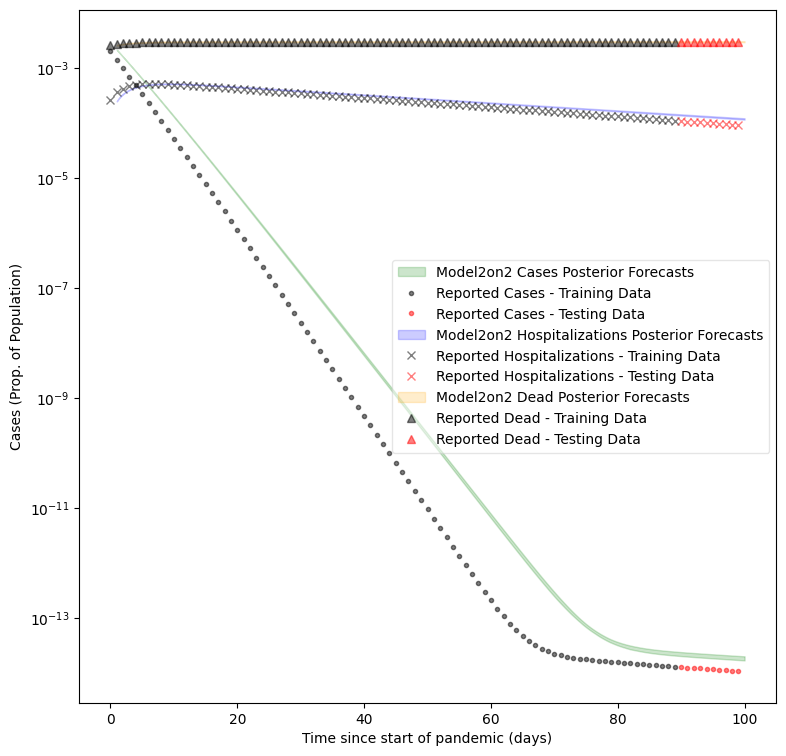

In [104]:
# Cases
ax = plot_predictive(ensemble_posterior_forecasts2on2, t_points, var_name="Cases_sol", ax=setup_ax(), color="green", label="Model2on2 Cases Posterior Forecasts")
ax = plot_observations(train_cases, train_timepoints, ax=ax, color="black", label="Reported Cases - Training Data")
ax = plot_observations(test_cases, test_timepoints, ax=ax, color="red", label="Reported Cases - Testing Data")

# Hospitalizations
train_df = synth_data_model2[(synth_data_model2['date'] >= train_start_date) & (synth_data_model2['date'] < test_start_date)]
test_df = synth_data_model2[(synth_data_model2['date'] >= test_start_date) & (synth_data_model2['date'] < test_end_date)]

train_hosps = np.array(train_df["hospital_census"].astype("float")) / data_total_population
test_hosps = np.array(test_df["hospital_census"].astype("float")) / data_total_population

train_dead = np.array(train_df["cumulative_deaths"].astype("float")) / data_total_population
test_dead = np.array(test_df["cumulative_deaths"].astype("float")) / data_total_population



ax = plot_predictive(ensemble_posterior_forecasts2on2, t_points, var_name="Hospitalizations_sol", ax=ax, color="blue", label="Model2on2 Hospitalizations Posterior Forecasts")
ax = plot_observations(train_hosps, train_timepoints, ax=ax, color="black", marker='x', label="Reported Hospitalizations - Training Data")
ax = plot_observations(test_hosps, test_timepoints, ax=ax, color="red", marker='x', label="Reported Hospitalizations - Testing Data")

ax = plot_predictive(ensemble_posterior_forecasts2on2, t_points, var_name="Dead_sol", ax=ax, color="orange", label="Model2on2 Dead Posterior Forecasts")
ax = plot_observations(train_dead, train_timepoints, ax=ax, color="black", marker='^', label="Reported Dead - Training Data")
ax = plot_observations(test_dead, test_timepoints, ax=ax, color="red", marker='^', label="Reported Dead - Testing Data")


In [105]:
param_median = {k[8:]: v[0].item() for k,v in inferred_parameters2on2.quantiles([0.50]).items()}
display(param_median)

param_actual = {b: c for (a,b,c) in model2_rate_parameter_intervention}
display(param_actual)

param_errs = {k:(v-param_median[k])/v for k,v in param_actual.items()}
display(param_errs)

{'mira_param_0': 9.227518749099772e-10,
 'mira_param_1': 3.8706380323105805e-09,
 'mira_param_2': 8.321030531277529e-10,
 'mira_param_3': 0.025225840508937836,
 'mira_param_4': 0.37833088636398315,
 'mira_param_5': 0.05011375993490219,
 'mira_param_6': 0.2679327130317688,
 'mira_param_7': 0.02097156085073948,
 'mira_param_8': 1.5695433616638184,
 'mira_param_9': 0.09384658932685852,
 'mira_param_10': 0.0002890694886445999,
 'mira_param_11': 0.0163666270673275,
 'ights': 1.0}

{'mira_param_0': 1e-09,
 'mira_param_1': 4e-09,
 'mira_param_2': 8.5e-10,
 'mira_param_3': 0.024,
 'mira_param_4': 0.44,
 'mira_param_5': 0.059,
 'mira_param_6': 0.31,
 'mira_param_7': 0.024,
 'mira_param_8': 1.7,
 'mira_param_9': 0.09,
 'mira_param_10': 0.0003,
 'mira_param_11': 0.019}

{'mira_param_0': 0.07724812509002282,
 'mira_param_1': 0.03234049192235495,
 'mira_param_2': 0.021055231614408306,
 'mira_param_3': -0.0510766878724098,
 'mira_param_4': 0.14015707644549283,
 'mira_param_5': 0.15061423839148824,
 'mira_param_6': 0.1357009257039716,
 'mira_param_7': 0.12618496455252173,
 'mira_param_8': 0.07673919902128329,
 'mira_param_9': -0.04273988140953915,
 'mira_param_10': 0.036435037851333535,
 'mira_param_11': 0.1385985754038158}

## Test model calibration for each model separately using the synthetic data as the training dataset

### Calibrate Model 1 using weighted sum synthetic data

In [41]:
train_data, train_cases, train_timepoints, test_cases, test_timepoints, all_timepoints = get_train_test_data(synth_data_df, train_start_date, test_start_date, test_end_date)

In [ ]:
# train_data.pop(0)

In [42]:
train_data

[(0.0,
  {'Cases': 0.002942814386272932,
   'Dead': 0.002435283542327681,
   'Hospitalizations': 0.000203000775142659}),
 (1.0,
  {'Cases': 0.0031760914174504854,
   'Dead': 0.0024854935123890328,
   'Hospitalizations': 0.0002689497809005108}),
 (2.0,
  {'Cases': 0.0036236130331410736,
   'Dead': 0.002520670809870189,
   'Hospitalizations': 0.0003331284064271835}),
 (3.0,
  {'Cases': 0.0043679438731212,
   'Dead': 0.002546883265305286,
   'Hospitalizations': 0.00040176097059316376}),
 (4.0,
  {'Cases': 0.005521496043861869,
   'Dead': 0.0025674708030427027,
   'Hospitalizations': 0.00048203769816451345}),
 (5.0,
  {'Cases': 0.007237744869220118,
   'Dead': 0.0025846080648491885,
   'Hospitalizations': 0.0005828631238591134}),
 (6.0,
  {'Cases': 0.00972224559399274,
   'Dead': 0.0025998339468554913,
   'Hospitalizations': 0.0007157581600400454}),
 (7.0,
  {'Cases': 0.01324113384541188,
   'Dead': 0.002614368342494674,
   'Hospitalizations': 0.000895903069821337}),
 (8.0,
  {'Cases': 0.0

In [46]:
# Run calibration and produce forecast samples
ensemble1 = setup_model([model1], weights=[1.0], start_time=-1, start_states=[start_state1], solution_mappings=[solution_mapping1])
inferred_parameters1 = calibrate(ensemble1, train_data, num_iterations=num_iterations, verbose=True, verbose_every=10, autoguide=autoguide)
ensemble_posterior_forecasts = sample(ensemble1, t_points, num_samples, inferred_parameters1)

iteration 0: loss = -8.416562557220459
iteration 10: loss = -13.71703290939331
iteration 20: loss = -23.49400234222412
iteration 30: loss = -36.64485955238342
iteration 40: loss = -42.406291007995605
iteration 50: loss = -48.99957060813904
iteration 60: loss = -51.36532258987427
iteration 70: loss = -57.81610155105591
iteration 80: loss = -57.13404417037964
iteration 90: loss = -57.7953782081604


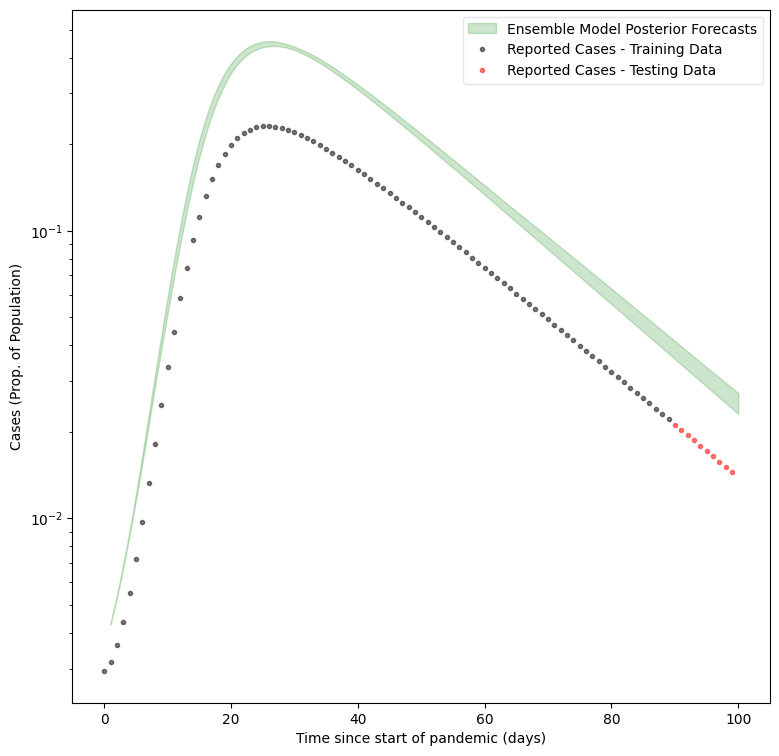

In [47]:
# Plot forecast vs. training/testing data
ax = plot_predictive(ensemble_posterior_forecasts, t_points, ax=setup_ax(), color="green", label="Ensemble Model Posterior Forecasts")
ax = plot_observations(train_cases, train_timepoints, ax=ax, color="black", label="Reported Cases - Training Data")
ax = plot_observations(test_cases, test_timepoints, ax=ax, color="red", label="Reported Cases - Testing Data")

In [160]:
# for p in inferred_parameters1.parameters():
#     print(p)
    
param_median = {k[8:]: v[0].item() for k,v in inferred_parameters1.quantiles([0.50]).items()}
display(param_median)

param_actual = {b: c for (a,b,c) in model1_rate_parameter_intervention}
display(param_actual)

param_errs = {k:(v-param_median[k])/v for k,v in param_actual.items()}
display(param_errs)


{'beta': 0.011149110272526741,
 'gamma': 0.4877762794494629,
 'delta': 0.011242439970374107,
 'alpha': 0.6135819554328918,
 'epsilon': 0.15940499305725098,
 'zeta': 0.13049086928367615,
 'XXlambdaXX': 0.032027266919612885,
 'eta': 0.13197042047977448,
 'rho': 0.03235701471567154,
 'theta': 0.35214346647262573,
 'kappa': 0.016831086948513985,
 'mu': 0.017565205693244934,
 'nu': 0.028771255165338516,
 'xi': 0.015711825340986252,
 'tau': 0.010743415914475918,
 'sigma': 0.0159625094383955,
 'ights': 1.0}

{'beta': 0.01,
 'gamma': 0.49,
 'delta': 0.11,
 'alpha': 0.61,
 'epsilon': 0.17,
 'zeta': 0.13,
 'XXlambdaXX': 0.036,
 'eta': 0.13,
 'rho': 0.036,
 'theta': 0.39,
 'kappa': 0.017,
 'mu': 0.017,
 'nu': 0.028,
 'xi': 0.017,
 'tau': 0.009,
 'sigma': 0.017}

{'beta': -0.11491102725267408,
 'gamma': 0.004538205205177756,
 'delta': 0.8977960002693263,
 'alpha': -0.005872058086707966,
 'epsilon': 0.06232357025146491,
 'zeta': -0.0037759175667395617,
 'XXlambdaXX': 0.1103536966774198,
 'eta': -0.015157080613649773,
 'rho': 0.10119403567579051,
 'theta': 0.09706803468557508,
 'kappa': 0.00993606185211862,
 'mu': -0.03324739372029017,
 'nu': -0.027544827333518415,
 'xi': 0.07577497994198525,
 'tau': -0.19371287938621318,
 'sigma': 0.061028856564970646}

## Test ensemble model calibration using synthetic data as the training dataset

In [42]:
# Redefine start states for synthetic testing data

synth_train_start_date = synth_data_df["date"][0]
synth_test_end_date = synth_data_df["date"][len(synth_data_df) - 1]
synth_test_start_date = synth_data_df["date"][30]

test_dates = pd.date_range(start=synth_train_start_date, end=synth_test_end_date, freq="1D")
test_dates = [date.strftime("%Y-%m-%d") for date in test_dates[1:-1]]
train_data, train_cases, train_timepoints, test_cases, test_timepoints, all_timepoints = get_train_test_data(synth_data_df, 
                                                                                                             synth_train_start_date, 
                                                                                                             synth_test_start_date, 
                                                                                                             synth_test_end_date)

synth_start_state1 = create_start_state1(synth_data_df, synth_train_start_date, data_total_population)
print("Start state 1", start_state1)

synth_start_state2 = create_start_state2(synth_data_df, synth_train_start_date, data_total_population)
print("Start state 2", start_state2)

synth_start_state3 = create_start_state3(synth_data_df, synth_train_start_date)
print("Start state 3", start_state3)

Start state 1 {'Extinct': 0.002354530664625813, 'Threatened': 0.00012599815642804597, 'Diagnosed': 0.0014301113146919957, 'Recognized': 0.0014301113146919957, 'Infected': 0.0014301113146919957, 'Ailing': 0.0014301113146919957, 'Healed': 0.023545306646258125, 'Susceptible': 0.96825371927392}
Start state 2 {'Deceased': 781454.0, 'Hospitalized': 41818.0, 'Infectious': 949290.0, 'Exposed': 1898580.0, 'Asymptomatic': 949290.0, 'Recovered': 7814540.0, 'Susceptible': 319458773.0}


AssertionError: 

In [73]:
# Setup the Ensemble

models = [model1, model2, model3]
weights = [1/3, 1/3, 1/3]

start_t = train_timepoints[0] - 1e-5
start_states = [start_state1, start_state2, start_state3]
solution_mappings = [solution_mapping1, solution_mapping2, solution_mapping3]

ensemble_total_population = 1.0
dirichlet_concentration = 1.0
noise_pseudocount = 100.0

ensemble = setup_model(models, 
                       weights, 
                       solution_mappings, 
                       start_t, 
                       start_states, 
                       ensemble_total_population, 
                       dirichlet_concentration=dirichlet_concentration,
                       noise_pseudocount=noise_pseudocount)
ensemble

NameError: name 'train_timepoints' is not defined

In [54]:
data_total_population

331893745

In [72]:
# Sample from the Ensemble
num_samples = 100
ensemble_prior_forecasts = sample(ensemble, all_timepoints, num_samples)

plotting_cases = np.array(synth_data_df["case_census"][all_timepoints.astype("int")].astype("float")) / data_total_population

ax = plot_predictive(ensemble_prior_forecasts, all_timepoints, ax=setup_ax(), title="Prior Forecasts - Ensemble", color="blue", label="Ensemble Model Prior Forecasts")
ax = plot_observations(plotting_cases, all_timepoints, ax=ax, color="black", label="Reported Cases")

NameError: name 'ensemble' is not defined

In [45]:
# Calibrate

num_iterations = 100

import pyro
import dill

save_path = "notebook/april_ensemble/saved_guides/"

try:
    with open(os.path.join(save_path, "inferred_parameters.pkl"), "rb") as f:
        inferred_parameters = dill.load(f)
    print("Loaded inferred parameters from file.")
except:
    autoguide = pyro.infer.autoguide.AutoDiagonalNormal
    inferred_parameters = calibrate(ensemble, train_data, num_iterations=num_iterations, verbose=True, verbose_every=10, autoguide=autoguide)

    with open(os.path.join(save_path, "inferred_parameters.pkl"), "wb") as f:
        dill.dump(inferred_parameters, f)

ModuleNotFoundError: No module named 'dill'

## Prior samples from each individual model

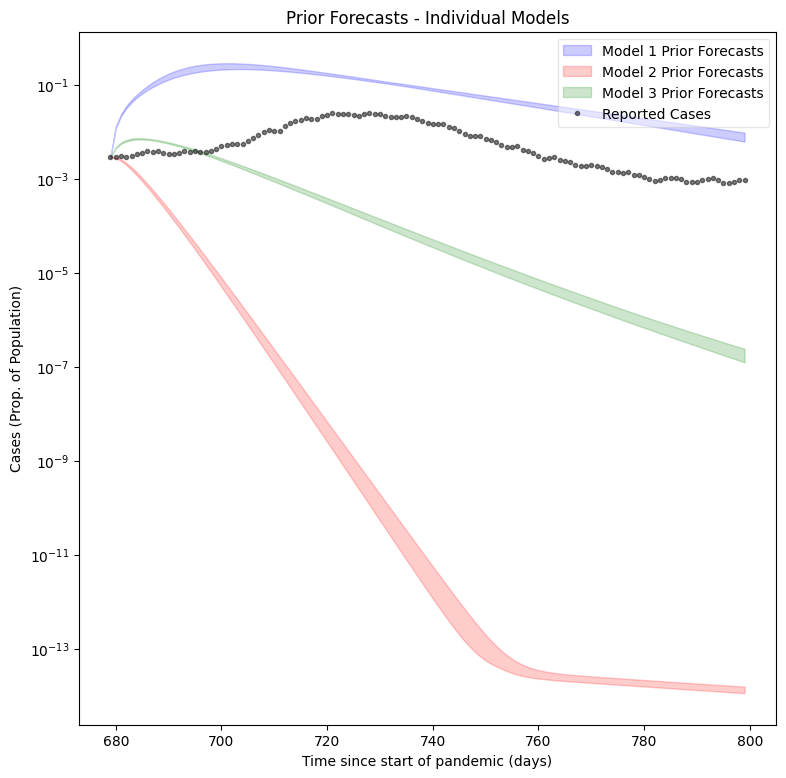

In [99]:
num_samples = 5 #100

start_time = train_timepoints[0] - 1e-5

# Wrapping model1 in a single "ensemble" model automatically applies the solution mapping functions, making these three models easier to compare.
ensemble1 = setup_model([model1], weights=[1.0], start_time=start_time, start_states=[start_state1], solution_mappings=[solution_mapping1])
ensemble1_prior_forecasts = sample(ensemble1, all_timepoints, num_samples)

ensemble2 = setup_model([model2], weights=[1.0], start_time=start_time, start_states=[start_state2], solution_mappings=[solution_mapping2])
ensemble2_prior_forecasts = sample(ensemble2, all_timepoints, num_samples)

ensemble3 = setup_model([model3], weights=[1.0], start_time=start_time, start_states=[start_state3], solution_mappings=[solution_mapping3])
ensemble3_prior_forecasts = sample(ensemble3, all_timepoints, num_samples)

plotting_cases = np.array(data["case_census"][all_timepoints].astype("float")) / data_total_population

# Plot trajectories from the prior.
ax = plot_predictive(ensemble1_prior_forecasts, all_timepoints, title="Prior Forecasts - Individual Models", ax=setup_ax(), color="blue", label="Model 1 Prior Forecasts")
ax = plot_predictive(ensemble2_prior_forecasts, all_timepoints, ax=ax, color="red", label="Model 2 Prior Forecasts")
ax = plot_predictive(ensemble3_prior_forecasts, all_timepoints, ax=ax, color="green", label="Model 3 Prior Forecasts")
ax = plot_observations(plotting_cases, all_timepoints, ax=ax, color="black", label="Reported Cases")

## NOTE: The MIRA models did not contain enough information to align the data with the start state. We constructed somewhat handwavy mappings manually based on data.

## Setup the full ensemble of all three models

In [100]:
# Setup the Ensemble

models = [model1, model2, model3]
weights = [1/3, 1/3, 1/3]

start_states = [start_state1, start_state2, start_state3]
solution_mappings = [solution_mapping1, solution_mapping2, solution_mapping3]

ensemble_total_population = 1.0
dirichlet_concentration = 1.0
noise_pseudocount = 100.0

ensemble = setup_model(models, 
                       weights, 
                       solution_mappings, 
                       start_time, 
                       start_states, 
                       ensemble_total_population, 
                       dirichlet_concentration=dirichlet_concentration,
                       noise_pseudocount=noise_pseudocount)
ensemble

Ensemble of 3 models. 

 	Dirichlet Alpha: tensor([0.3333, 0.3333, 0.3333]). 

 	Models: [ScaledBetaNoisePetriNetODESystem(
	beta = Uniform(low: 0.00989999994635582, high: 0.01209999993443489),
	gamma = Uniform(low: 0.41040000319480896, high: 0.5016000270843506),
	delta = Uniform(low: 0.00989999994635582, high: 0.01209999993443489),
	alpha = Uniform(low: 0.5130000114440918, high: 0.6269999742507935),
	epsilon = Uniform(low: 0.15389999747276306, high: 0.18809999525547028),
	zeta = Uniform(low: 0.11249999701976776, high: 0.13750000298023224),
	XXlambdaXX = Uniform(low: 0.03060000017285347, high: 0.03739999979734421),
	eta = Uniform(low: 0.11249999701976776, high: 0.13750000298023224),
	rho = Uniform(low: 0.03060000017285347, high: 0.03739999979734421),
	theta = Uniform(low: 0.33390000462532043, high: 0.4081000089645386),
	kappa = Uniform(low: 0.015300000086426735, high: 0.018699999898672104),
	mu = Uniform(low: 0.015300000086426735, high: 0.018699999898672104),
	nu = Uniform(low: 0.02429

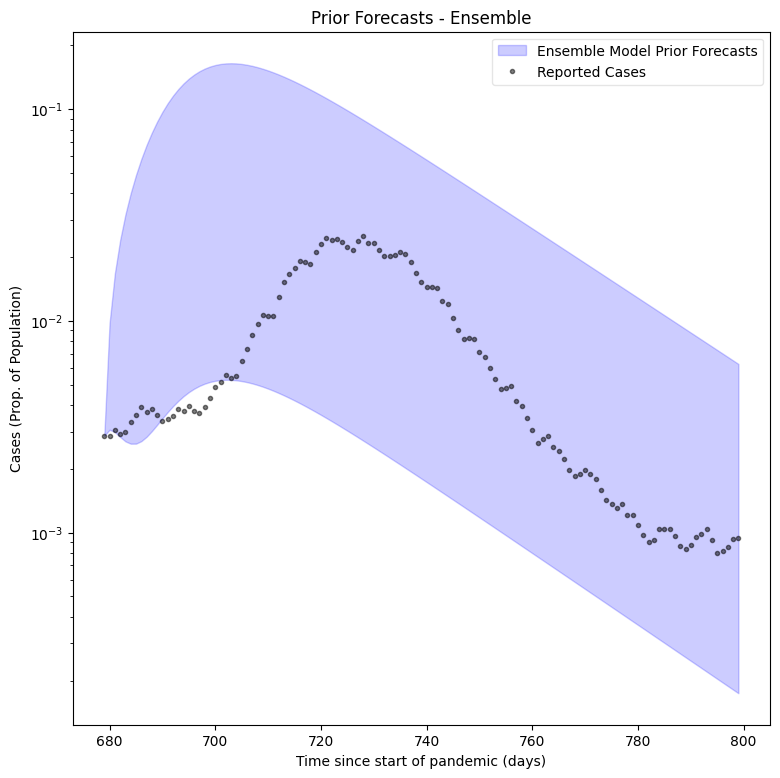

In [101]:
# Sample from the Ensemble
ensemble_prior_forecasts = sample(ensemble, all_timepoints, num_samples)
ax = plot_predictive(ensemble_prior_forecasts, all_timepoints, ax=setup_ax(), title="Prior Forecasts - Ensemble", color="blue", label="Ensemble Model Prior Forecasts")
ax = plot_observations(plotting_cases, all_timepoints, ax=ax, color="black", label="Reported Cases")

<Axes: title={'center': 'Prior Ensemble Weights'}>

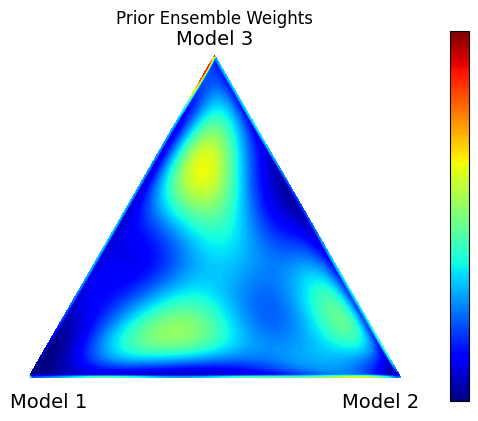

In [ ]:
plot_weights(ensemble_prior_forecasts["model_weights"], title="Prior Ensemble Weights")


## Calibration

In [ ]:
num_iterations = 100

In [ ]:
import pyro
import dill

save_path = "notebook/april_ensemble/saved_guides/"

try:
    with open(os.path.join(save_path, "inferred_parameters.pkl"), "rb") as f:
        inferred_parameters = dill.load(f)
    print("Loaded inferred parameters from file.")
except:
    autoguide = pyro.infer.autoguide.AutoDiagonalNormal
    inferred_parameters = calibrate(ensemble, train_data, num_iterations=num_iterations, verbose=True, verbose_every=10, autoguide=autoguide)

    with open(os.path.join(save_path, "inferred_parameters.pkl"), "wb") as f:
        dill.dump(inferred_parameters, f)

Loaded inferred parameters from file.


In [ ]:
try:
    with open(os.path.join(save_path, "deterministic_parameters.pkl"), "rb") as f:
        deterministic_parameters = dill.load(f)
    print("Loaded deterministic parameters from file.")
except: 
    deterministic_autoguide = pyro.infer.autoguide.AutoDelta
    deterministic_parameters = calibrate(ensemble, train_data, num_iterations=num_iterations, verbose=True, verbose_every=10, autoguide=deterministic_autoguide)

    with open(os.path.join(save_path, "deterministic_parameters.pkl"), "wb") as f:
        dill.dump(deterministic_parameters, f)

Loaded deterministic parameters from file.


In [ ]:
ensemble_posterior_forecasts = sample(ensemble, all_timepoints, num_samples, inferred_parameters)
ensemble_deterministic_forecasts = sample(ensemble, all_timepoints, 1, deterministic_parameters)

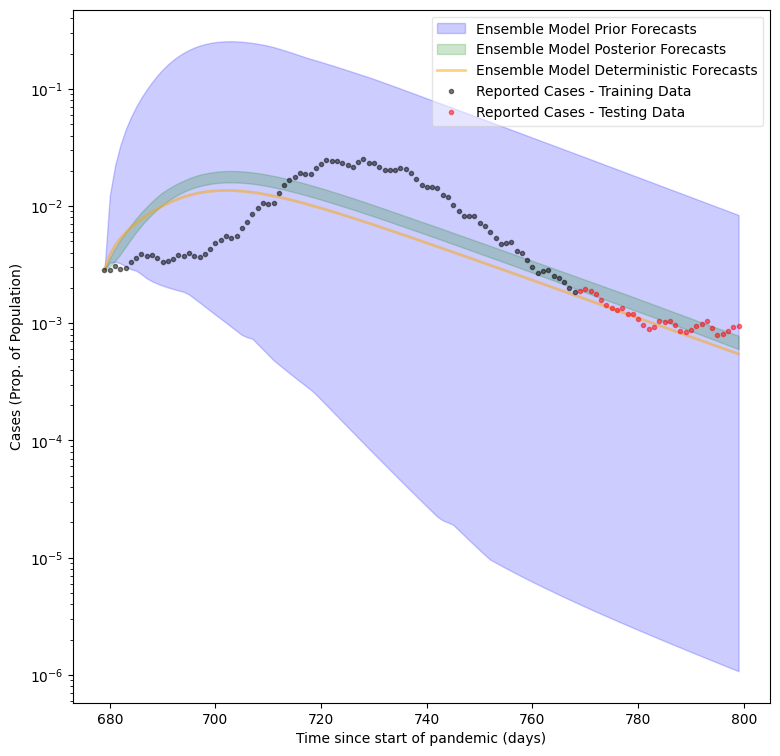

In [ ]:
# Sample from the Ensemble
ax = plot_predictive(ensemble_prior_forecasts, all_timepoints, ax=setup_ax(), color="blue", label="Ensemble Model Prior Forecasts")
ax = plot_predictive(ensemble_posterior_forecasts, all_timepoints, ax=ax, color="green", label="Ensemble Model Posterior Forecasts")
ax = plot_trajectory(ensemble_deterministic_forecasts, all_timepoints, ax=ax, color="orange", label="Ensemble Model Deterministic Forecasts")
ax = plot_observations(train_cases, train_timepoints, ax=ax, color="black", label="Reported Cases - Training Data")
ax = plot_observations(test_cases, test_timepoints, ax=ax, color="red", label="Reported Cases - Testing Data")

<Axes: title={'center': 'Posterior Ensemble Weights'}>

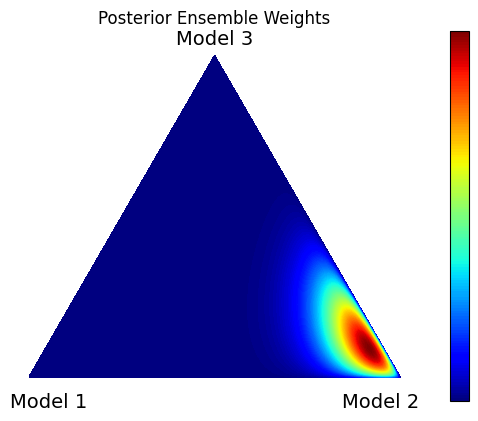

In [ ]:
plot_weights(ensemble_posterior_forecasts["model_weights"], title="Posterior Ensemble Weights")

## Forecasting over time - Sliding Window Calibration

In [ ]:
sliding_window_train_start_date = "2020-08-01"
sliding_window_train_end_date = "2022-01-15"

In [ ]:
dates = pd.date_range(start=sliding_window_train_start_date, end=test_end_date, freq="14D")
dates = [date.strftime("%Y-%m-%d") for date in dates[1:-1]]

Running analysis for sliding window starting at 2020-08-15
Running analysis for sliding window starting at 2020-08-29
Running analysis for sliding window starting at 2020-09-12
Running analysis for sliding window starting at 2020-09-26
Running analysis for sliding window starting at 2020-10-10
Running analysis for sliding window starting at 2020-10-24
Running analysis for sliding window starting at 2020-11-07
Running analysis for sliding window starting at 2020-11-21
Running analysis for sliding window starting at 2020-12-05
Running analysis for sliding window starting at 2020-12-19
Running analysis for sliding window starting at 2021-01-02
Running analysis for sliding window starting at 2021-01-16
Running analysis for sliding window starting at 2021-01-30
Running analysis for sliding window starting at 2021-02-13
Running analysis for sliding window starting at 2021-02-27
Running analysis for sliding window starting at 2021-03-13
Running analysis for sliding window starting at 2021-03-

KeyboardInterrupt: 

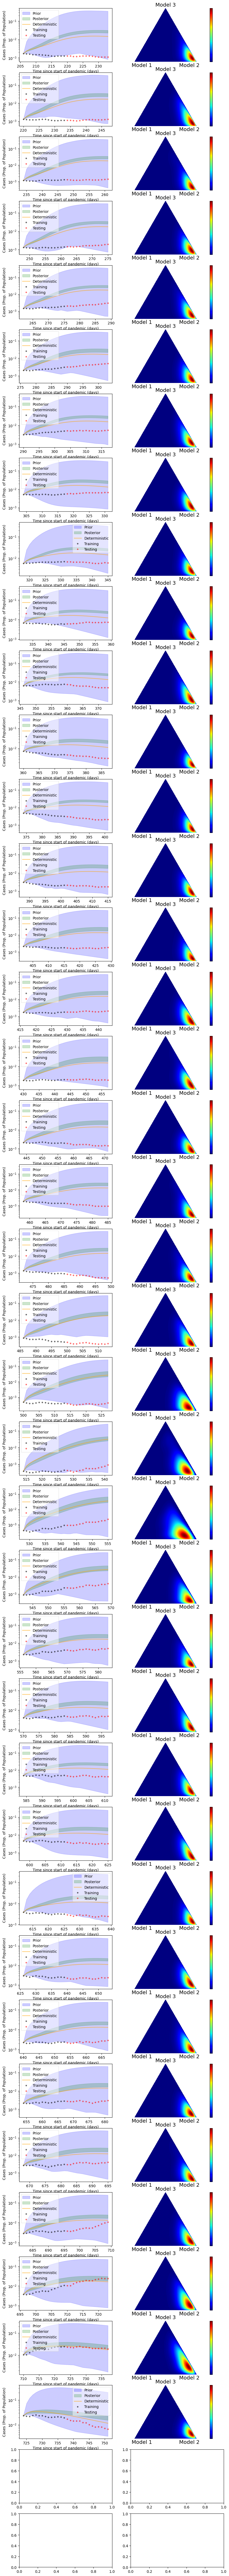

In [ ]:
# Setup plt axes
fig, axes = plt.subplots(nrows=len(dates)-2, ncols=2, figsize=(10, 3*len(dates)))

for i in range(1, len(dates)-1):
    _train_start_date = dates[i-1]
    _test_start_date = dates[i]
    _test_end_date = dates[i+1]
    print(f"Running analysis for sliding window starting at {_train_start_date}")
    
    _train_data, _train_cases, _train_timepoints, _test_cases, _test_timepoints, _all_timepoints = get_train_test_data(data, _train_start_date, _test_start_date, _test_end_date)
    _start_states = [create_start_state1(data, _train_start_date), create_start_state2(data, _train_start_date), create_start_state3(data, _train_start_date)]
    _start_time = _train_timepoints[0] - 1e-5

    _ensemble = setup_model(models, 
                        weights, 
                        solution_mappings, 
                        _start_time, 
                        _start_states, 
                        ensemble_total_population, 
                        dirichlet_concentration=dirichlet_concentration,
                        noise_pseudocount=noise_pseudocount)
    
    _ensemble_prior_forecasts = sample(_ensemble, _all_timepoints, num_samples)

    try:
        with open(os.path.join(save_path, f"inferred_parameters_{_train_start_date}.pkl"), "rb") as f:
            _inferred_parameters = dill.load(f)
    except:
        _autoguide = pyro.infer.autoguide.AutoDiagonalNormal
        _inferred_parameters = calibrate(_ensemble, _train_data, num_iterations=num_iterations, autoguide=_autoguide)

        with open(os.path.join(save_path, f"inferred_parameters_{_train_start_date}.pkl"), "wb") as f:
            dill.dump(_inferred_parameters, f)

    _ensemble_posterior_forecasts = sample(_ensemble, _all_timepoints, num_samples, _inferred_parameters)

    try:
        with open(os.path.join(save_path, f"deterministic_parameters_{_train_start_date}.pkl"), "rb") as f:
            _deterministic_parameters = dill.load(f)
    except:
        _deterministic_autoguide = pyro.infer.autoguide.AutoDelta
        _deterministic_parameters = calibrate(_ensemble, _train_data, num_iterations=num_iterations, autoguide=_deterministic_autoguide)
        _ensemble_deterministic_forecasts = sample(_ensemble, _all_timepoints, 1, _deterministic_parameters)

        with open(os.path.join(save_path, f"deterministic_parameters_{_train_start_date}.pkl"), "wb") as f:
            dill.dump(_deterministic_parameters, f)
    
    ax = setup_ax(axes[i-1, 0])
    ax = plot_predictive(_ensemble_prior_forecasts, _all_timepoints, ax=ax, color="blue", label="Prior")
    ax = plot_predictive(_ensemble_posterior_forecasts, _all_timepoints, ax=ax, color="green", label="Posterior")
    ax = plot_trajectory(_ensemble_deterministic_forecasts, _all_timepoints, ax=ax, color="orange", label="Deterministic")
    ax = plot_observations(_train_cases, _train_timepoints, ax=ax, color="black", label="Training")
    ax = plot_observations(_test_cases, _test_timepoints, ax=ax, color="red", label="Testing")
    
    plot_weights(_ensemble_posterior_forecasts["model_weights"], ax=axes[i-1, 1])